In [1]:
import numpy as np
import pandas as pd

In [2]:
threshold = 3
cutoff = 8

## Build the Transition Matrix of Probabilities is given
### - on rows we have current state
### - on columns we have new state

In [3]:
edges = pd.read_csv(f'edges.20211117_v3.csv',
                    low_memory=False, 
                    encoding='utf-8',
                    float_precision='round_trip')

In [4]:
edges.shape

(10015, 9)

In [5]:
edges.head()

HRTB Id Event Effective Date  seq_id  \
0      423           2007-07-10     1.0   
1      423           2008-06-02     2.0   
2      423           2008-12-19     3.0   
3      423           2011-02-08     4.0   
4      464           2010-09-27     1.0   

                                    position_from                position_to  \
0                       game designer(artistique)              game designer   
1                                   game designer          camera specialist   
2                               camera specialist              game designer   
3                                   game designer             audio designer   
4  network administrator(services professionnels)  senior applications admin   

   upd      position_from_upd            position_to_upd  transition_days  
0    1          game designer              game designer                0  
1    0          game designer          camera specialist                0  
2    0      camera specialist              game designer                0  
3    0          game designer             audio designer                0  
4    1  network administrator  senior applications admin                0

In [6]:
edges = edges[edges['position_from_upd'] != edges['position_to_upd']]

## Replace space with "_"

In [7]:
edges['position_from_upd'] = edges['position_from_upd'].str.replace(" ", "_")
edges['position_to_upd'] = edges['position_to_upd'].str.replace(" ", "_")

In [8]:
len(edges['position_to'].unique()), len(edges['position_to_upd'].unique())

(1191, 1101)

In [9]:
edges_agg = edges.groupby(['position_from_upd','position_to_upd'])['HRTB Id'].count()

In [10]:
edges_agg.shape

(3589,)

In [11]:
edges_agg = edges_agg[edges_agg >= threshold]

In [12]:
edges_agg.sort_values(ascending = False).head(10)

position_from_upd      position_to_upd           
tester                 development_tester            160
generalist_programmer  game_play_programmer          105
                       programming_team_lead         100
modeler                level_artist                   88
programming_team_lead  project_lead_-_programming     80
level_artist           graphic_design_team_lead       74
generalist_programmer  online_programmer              74
                       technical_lead                 66
3d_animator            gameplay_animator              65
game_play_programmer   programming_team_lead          59
Name: HRTB Id, dtype: int64

In [13]:
edges_agg.loc[('level_designer','level_design_team_lead')]

51

In [14]:
edges_agg.loc[('level_designer','team_lead')]

3

In [15]:
edges_agg.loc[('level_designer',)]

position_to_upd
assistant_director_-_level_design        33
assistant_technical_director_-_design    18
camera_specialist                         7
cinematic_designer                        4
development_tester                        3
director_-_level_design                  14
event_scripter                           17
game_designer                            25
integrator                                8
level_design_team_lead                   51
scriptwriter                              3
team_lead                                 3
technical_designer                       25
technical_director_-_design              16
Name: HRTB Id, dtype: int64

## Average number of positions per employee

In [16]:
edges.groupby('HRTB Id')['position_from_upd'].nunique().mean()

1.9330316742081448

<AxesSubplot:>

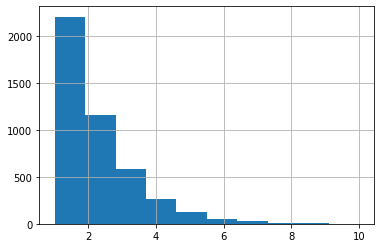

In [17]:
edges.groupby('HRTB Id')['position_from_upd'].nunique().hist()

## Create states

In [18]:
allstates = set(edges_agg.index.get_level_values(0)).union(set(edges_agg.index.get_level_values(1)))
n = len(allstates)
print("n=",n)
states = list(allstates)

n= 287


## Create transition probability matrix

In [19]:
edges_agg.loc[('character_modeler', 'graphic_design_team_lead')]

20

In [20]:
# init with 0
tpm = [[0 for i in range(n)] for j in range(n)]
# populate with nij = number of transition from i to j
for i,source in enumerate(allstates):
    if i % 100 == 0:
        print(i, source)
    for j,dest in enumerate(allstates):
        if i != j:
            try:
                hrcnt = edges_agg.loc[(source, dest)]
                tpm[i][j] = hrcnt
            except:
                pass;
        else:
            tpm[i][j] = 0

0 brand_director
100 artistic_director_-_graphic
200 assistant_executive_producer


In [21]:
p = [[0 for i in range(n)] for j in range(n)]
for i in range(n):
    i_sum = 0
    for j in range(n):
        i_sum = i_sum + tpm[i][j]
    if i_sum > 0:
        for j in range(n):
            p[i][j] = tpm[i][j]/i_sum
    else:
        p[i][i] = 1

In [22]:
for i in range(n):
    if round(sum(p[i])) != 1:
        print(i, sum(p[i]), "Somewhere, something went wrong. Transition matrix, perhaps?")

In [23]:
len(p), len(p[0])

(287, 287)

## Remove rows and cols with 0

In [24]:
pa = np.array(p)
dim = len(pa[0])
pa.shape, dim

((287, 287), 287)

In [25]:
len(pa[1,:]), len(pa[:,1])

(287, 287)

In [26]:
for i in range(len(p)):
    if sum(pa[i,:]) == 0:
        if sum(pa[:,i]) == 0:
            print(i)

## Build the graph with:
### 1 - vertex = states
### 2- edges weight = -log(p(i,j)

In [27]:
import networkx as nx  # For the magic
import pydot
import matplotlib.pyplot as plt  # For plotting

In [28]:
G = nx.DiGraph()
labels={}
edge_labels={}

for i, origin_state in enumerate(states):
    for j, destination_state in enumerate(states):
        if i!=j:
            try:
#                 rate = 1/np.log(1.01 + p[i][j])
                rate = -np.log(p[i][j])
#                 print(p[i][j], rate)
            except:
                rate = 0
            if rate > 0:
                print(origin_state, destination_state, p[i][j])                
            if p[i][j] > 0:          
                G.add_edge(origin_state,
                           destination_state,
                           weight = rate,
                           prob = p[i][j],
                           hrcnt = tpm[i][j]
                          )
    #             edge_labels[(origin_state, destination_state)] = label="{:.02f}".format(rate)

<ipython-input-28-bf8361cfc7f6>:10: RuntimeWarning: divide by zero encountered in log
  rate = -np.log(p[i][j])


brand_director development_advisor 0.0
brand_director associate_presentation_director 0.0
brand_director product_manager_-_management 0.0
brand_director executive_producer 0.0
brand_director project_manager 0.0
brand_director project_&_account_manager(services_professionnels) 0.0
brand_director intégrateur_localisation(artistique) 0.0
brand_director security_team_lead 0.0
brand_director integrator 0.0
brand_director ux_designer 0.0
brand_director storyboardist 0.0
brand_director monetization_specialist 0.0
brand_director project_lead_-_graphic 0.0
brand_director linux_systems_administrator 0.0
brand_director talent_acquisition_specialist 0.0
brand_director artistic_director_visual_design 0.0
brand_director producer(producteurs) 0.0
brand_director product_manager_-_programming 0.0
brand_director production_manager_-_it 0.0
brand_director creative_director 0.0
brand_director level_artist 0.0
brand_director analytics_team_lead 0.0
brand_director project_lead_-_game_design 0.0
brand_direct

product_manager_-_management data_architect 0.0
product_manager_-_management 2d-3d_artist 0.0
product_manager_-_management sound_designer 0.0
product_manager_-_management lead_programmeur_ai 0.0
product_manager_-_management dev_test_team_lead 0.0
product_manager_-_management network_administrator 0.0
product_manager_-_management associate_user_experience_director 0.0
product_manager_-_management user_research_lab_team_lead 0.0
product_manager_-_management analyst_programmer 0.0
product_manager_-_management artistic_director_-_graphic 0.0
product_manager_-_management gameplay_animator 0.0
product_manager_-_management cinematic_animator 0.0
product_manager_-_management technical_writer_(qc) 0.0
product_manager_-_management it_project_manager 0.0
product_manager_-_management helpdesk_specialist 0.0
product_manager_-_management voice_designer 0.0
product_manager_-_management communication_team_lead 0.0
product_manager_-_management ergonomist 0.0
product_manager_-_management special_effect_

project_&_account_manager(services_professionnels) intern_-_programmer 0.0
project_&_account_manager(services_professionnels) product_specialist_-_tools_and_automation 0.0
project_&_account_manager(services_professionnels) hr_coordinator(services_professionnels) 0.0
project_&_account_manager(services_professionnels) realization_director 0.0
project_&_account_manager(services_professionnels) 3d_programming_team_lead 0.0
project_&_account_manager(services_professionnels) assistant_artistic_director_-_graphic 0.0
project_&_account_manager(services_professionnels) 3d_programmer 0.0
project_&_account_manager(services_professionnels) game_design_team_lead 0.0
project_&_account_manager(services_professionnels) project_lead_-_level_design 0.0
project_&_account_manager(services_professionnels) tester 0.0
project_&_account_manager(services_professionnels) accountant 0.0
project_&_account_manager(services_professionnels) data_manager(informatique) 0.0
project_&_account_manager(services_profession

ux_designer operations_and_logistics_coordinator 0.0
ux_designer lead_scriptwriter 0.0
ux_designer stag_informatique_t3 0.0
ux_designer lead_audio_designer 0.0
ux_designer game_release_specialist 0.0
ux_designer audio_programmer 0.0
ux_designer audio_director 0.0
ux_designer lighter 0.0
ux_designer illustrator 0.0
ux_designer hr_partner 0.0
ux_designer capture_artist 0.0
ux_designer administrative_coordinator 0.0
ux_designer assistant_cinematic_director 0.0
ux_designer game_play_programmer 0.0
ux_designer tool_support_specialist 0.0
ux_designer administrative_technician 0.0
ux_designer purchasing_technician 0.0
ux_designer technical_writer(tools_automation) 0.0
ux_designer online_programmer 0.0
ux_designer live_operations_project_manager 0.0
ux_designer assistant_executive_producer 0.0
ux_designer lead_community_developer 0.0
ux_designer security_researcher 0.0
ux_designer hr_specialist 0.0
ux_designer marketing_game_manager(services_professionnels) 0.0
ux_designer mocap_specialist 0.0

project_lead_-_graphic it_project_manager 0.0
project_lead_-_graphic helpdesk_specialist 0.0
project_lead_-_graphic voice_designer 0.0
project_lead_-_graphic communication_team_lead 0.0
project_lead_-_graphic ergonomist 0.0
project_lead_-_graphic special_effect_artist 0.0
project_lead_-_graphic budget_analyst 0.0
project_lead_-_graphic network_programmer 0.0
project_lead_-_graphic financial_analyst 0.0
project_lead_-_graphic user_research_lab_coordinator 0.0
project_lead_-_graphic development_director 0.0
project_lead_-_graphic production_manager_-_it(gestion) 0.0
project_lead_-_graphic development_test_coordinator 0.0
project_lead_-_graphic microsoft_systems_administrator 0.0
project_lead_-_graphic directeur_production(gestion) 0.0
project_lead_-_graphic game_economy_designer 0.0
project_lead_-_graphic scriptwriter 0.0
project_lead_-_graphic presentation_director 0.0
project_lead_-_graphic technical_director_-_design 0.0
project_lead_-_graphic r&d_programmer 0.0
project_lead_-_graphic

producer(producteurs) engine_programmer 0.0
producer(producteurs) management_control_manager 0.0
producer(producteurs) rigger 0.0
producer(producteurs) story_designer 0.0
producer(producteurs) programming_team_lead 0.0
producer(producteurs) applications_specialist 0.0
producer(producteurs) community_management_specialist 0.0
producer(producteurs) it_production_coordinator(services_professionnels) 0.0
producer(producteurs) talent_development_coordinator 0.0
producer(producteurs) game_director 0.0
producer(producteurs) production_manager 0.0
producer(producteurs) technical_director_-_pipeline 0.0
producer(producteurs) database_administrator 0.0
producer(producteurs) technical_director_-_animation 0.0
producer(producteurs) team_lead_service_technique 0.0
producer(producteurs) production_manager_-_services 0.0
producer(producteurs) live_operations_manager 0.0
producer(producteurs) développeur_-_applications_web(informatique) 0.0
producer(producteurs) security_specialist 0.0
producer(produc

creative_director logistics_clerk 0.0
creative_director internal_community_specialist 0.0
creative_director receptionist 0.0
creative_director product_manager_tech_group(services_professionnels) 0.0
creative_director game_designer 0.5714285714285714
creative_director product_specialist_-_design 0.0
creative_director game_release_coordinator 0.0
creative_director mocap_technician 0.0
creative_director technical_architect 0.0
creative_director project_lead_-_tools_automation 0.0
creative_director project_lead_-_animation 0.0
creative_director projects_&_accounts_manager 0.0
creative_director it_development_team_lead 0.0
creative_director music_supervisor 0.0
creative_director senior_hr_adviser 0.0
creative_director audio_artist 0.0
creative_director cinematic_designer 0.0
creative_director graphic_designer 0.0
creative_director associate_monetization_director 0.0
creative_director technical_designer 0.0
creative_director business_strategy_and_live_performance_director 0.0
creative_direct

project_lead_-_game_design administrative_clerk 0.0
project_lead_-_game_design web_developer 0.0
project_lead_-_game_design animation_programmer 0.0
project_lead_-_game_design cinematics_camera_specialist 0.0
project_lead_-_game_design gameplay_camera_specialist 0.0
project_lead_-_game_design data_analyst 0.0
project_lead_-_game_design controller 0.0
project_lead_-_game_design accounting_technician 0.0
project_lead_-_game_design executive_assistant 0.0
project_lead_-_game_design quality_assurance_analyst 0.0
project_lead_-_game_design hr_manager 0.0
project_lead_-_game_design game_intelligence_analyst 0.0
project_lead_-_game_design user_interface_artist 0.0
project_lead_-_game_design risk_management_analyst 0.0
project_lead_-_game_design team_lead_mocap 0.0
project_lead_-_game_design production_manager_-_helix 0.0
project_lead_-_game_design talent_acquisition_team_lead 0.0
project_lead_-_game_design product_director_-_mkg 0.0
project_lead_-_game_design actionscript_developer 0.0
projec

3d_animator scriptwriter 0.0
3d_animator presentation_director 0.0
3d_animator technical_director_-_design 0.0
3d_animator r&d_programmer 0.0
3d_animator human_resources_director 0.0
3d_animator live_qa_specialist_tester 0.0
3d_animator development_tester 0.0
3d_animator it_data_analyst 0.0
3d_animator cinematic_director 0.0
3d_animator music_design_specialist 0.0
3d_animator technical_director_-_graphic 0.0
3d_animator technical_lead 0.0
3d_animator stag_informatique_t4 0.0
3d_animator monetization_director 0.0
3d_animator assistante_administrative 0.0
3d_animator sony_compliance_specialist_tester 0.0
3d_animator technology_director 0.0
3d_animator commis_comptable 0.0
3d_animator generalist_programmer 0.0
3d_animator assistant_director_-_level_design 0.0
3d_animator localization_project_manager 0.0
3d_animator project_lead_-_qc 0.0
3d_animator producer 0.0
3d_animator project_closer 0.0
3d_animator tools_tester(contrôle_qualité) 0.0
3d_animator qa_programmer 0.0
3d_animator it_techni

modeler executive_assistant 0.0
modeler quality_assurance_analyst 0.0
modeler hr_manager 0.0
modeler game_intelligence_analyst 0.0
modeler user_interface_artist 0.0
modeler risk_management_analyst 0.0
modeler team_lead_mocap 0.0
modeler production_manager_-_helix 0.0
modeler talent_acquisition_team_lead 0.0
modeler product_director_-_mkg 0.0
modeler actionscript_developer 0.0
modeler programming_team_lead(it_corpo) 0.0
modeler interface_developer 0.0
modeler user_research_project_manager 0.0
modeler product_specialist_-_programming 0.0
modeler system_administrator_-_command_center 0.0
modeler assistant_technical_director_-_design 0.0
modeler operations_analyst_-_quality_assurance 0.0
modeler team_lead_playtest 0.0
modeler tools_programmer 0.0
modeler product_director 0.0
modeler communication_coordinator 0.0
modeler support_analyst 0.0
modeler ai_programmer 0.0
modeler production_manager_–_co-development 0.0
modeler bi_developer 0.0
modeler technical_director_-_character 0.0
modeler te

operations_and_it_production_manager monetization_director 0
operations_and_it_production_manager assistante_administrative 0
operations_and_it_production_manager sony_compliance_specialist_tester 0
operations_and_it_production_manager technology_director 0
operations_and_it_production_manager commis_comptable 0
operations_and_it_production_manager generalist_programmer 0
operations_and_it_production_manager assistant_director_-_level_design 0
operations_and_it_production_manager localization_project_manager 0
operations_and_it_production_manager project_lead_-_qc 0
operations_and_it_production_manager producer 0
operations_and_it_production_manager project_closer 0
operations_and_it_production_manager tools_tester(contrôle_qualité) 0
operations_and_it_production_manager qa_programmer 0
operations_and_it_production_manager it_technician 0
operations_and_it_production_manager artistic_director_-_animation 0
operations_and_it_production_manager associate_product_manager_-_mkg 0
operation

product_manager_-_mkg live_producer 0.0
product_manager_-_mkg research_moderator 0.0
product_manager_-_mkg events_communication_specialist 0.0
product_manager_-_mkg technical_localization_specialist 0.0
product_manager_-_mkg ui_programmer 0.0
product_manager_-_mkg camera_specialist(artistique) 0.0
product_manager_-_mkg graphic_design_team_lead 0.0
product_manager_-_mkg it_manager 0.0
product_manager_-_mkg purchasing_team_lead 0.0
assistant_technical_director_-_animation brand_director 0.0
assistant_technical_director_-_animation development_advisor 0.0
assistant_technical_director_-_animation associate_presentation_director 0.0
assistant_technical_director_-_animation product_manager_-_management 0.0
assistant_technical_director_-_animation executive_producer 0.0
assistant_technical_director_-_animation project_manager 0.0
assistant_technical_director_-_animation project_&_account_manager(services_professionnels) 0.0
assistant_technical_director_-_animation intégrateur_localisation(art

ergonomist_team_lead graphic_designer 0
ergonomist_team_lead associate_monetization_director 0
ergonomist_team_lead technical_designer 0
ergonomist_team_lead business_strategy_and_live_performance_director 0
ergonomist_team_lead data_scientist 0
ergonomist_team_lead cloud_developer 0
ergonomist_team_lead project_&_account_manager 0
ergonomist_team_lead associate_game_director 0
ergonomist_team_lead director 0
ergonomist_team_lead tg_coordinator 0
ergonomist_team_lead event_scripter 0
ergonomist_team_lead associate_producer_–_co-development 0
ergonomist_team_lead human_resources_coordinator 0
ergonomist_team_lead it_service_director 0
ergonomist_team_lead operations_and_logistics_coordinator 0
ergonomist_team_lead lead_scriptwriter 0
ergonomist_team_lead stag_informatique_t3 0
ergonomist_team_lead lead_audio_designer 0
ergonomist_team_lead game_release_specialist 0
ergonomist_team_lead audio_programmer 0
ergonomist_team_lead audio_director 0
ergonomist_team_lead lighter 0
ergonomist_tea

release_&_build_specialist system_administrator_-_command_center 0.0
release_&_build_specialist assistant_technical_director_-_design 0.0
release_&_build_specialist operations_analyst_-_quality_assurance 0.0
release_&_build_specialist team_lead_playtest 0.0
release_&_build_specialist tools_programmer 0.2631578947368421
release_&_build_specialist product_director 0.0
release_&_build_specialist communication_coordinator 0.0
release_&_build_specialist support_analyst 0.0
release_&_build_specialist ai_programmer 0.0
release_&_build_specialist production_manager_–_co-development 0.0
release_&_build_specialist bi_developer 0.0
release_&_build_specialist technical_director_-_character 0.0
release_&_build_specialist tech_lead_release_&_build 0.21052631578947367
release_&_build_specialist marketing_game_manager(autres) 0.0
release_&_build_specialist character_modeler 0.0
release_&_build_specialist assistant_technical_director_-_graphic 0.0
release_&_build_specialist associate_producer 0.0
relea

story_designer qa_programmer 0.0
story_designer it_technician 0.0
story_designer artistic_director_-_animation 0.0
story_designer associate_product_manager_-_mkg 0.0
story_designer logistics_clerk 0.0
story_designer internal_community_specialist 0.0
story_designer receptionist 0.0
story_designer product_manager_tech_group(services_professionnels) 0.0
story_designer game_designer 0.0
story_designer product_specialist_-_design 0.0
story_designer game_release_coordinator 0.0
story_designer mocap_technician 0.0
story_designer technical_architect 0.0
story_designer project_lead_-_tools_automation 0.0
story_designer project_lead_-_animation 0.0
story_designer projects_&_accounts_manager 0.0
story_designer it_development_team_lead 0.0
story_designer music_supervisor 0.0
story_designer senior_hr_adviser 0.0
story_designer audio_artist 0.0
story_designer cinematic_designer 0.0
story_designer graphic_designer 0.0
story_designer associate_monetization_director 0.0
story_designer technical_designe

it_production_coordinator(services_professionnels) it_architect 0.0
it_production_coordinator(services_professionnels) directeur_-_artistique 0.0
it_production_coordinator(services_professionnels) release_&_build_specialist 0.0
it_production_coordinator(services_professionnels) engine_programmer 0.0
it_production_coordinator(services_professionnels) management_control_manager 0.0
it_production_coordinator(services_professionnels) rigger 0.0
it_production_coordinator(services_professionnels) story_designer 0.0
it_production_coordinator(services_professionnels) programming_team_lead 0.0
it_production_coordinator(services_professionnels) applications_specialist 0.0
it_production_coordinator(services_professionnels) community_management_specialist 0.0
it_production_coordinator(services_professionnels) talent_development_coordinator 0.0
it_production_coordinator(services_professionnels) game_director 0.0
it_production_coordinator(services_professionnels) production_manager 0.0
it_production

production_manager purchasing_agent 0.0
production_manager community_developer 0.0
production_manager concept_artist 0.0
production_manager studio_production_manager 0.0
production_manager codev_outsourcing_project_manager 0.044444444444444446
production_manager intern_-_programmer 0.0
production_manager product_specialist_-_tools_and_automation 0.0
production_manager hr_coordinator(services_professionnels) 0.0
production_manager realization_director 0.0
production_manager 3d_programming_team_lead 0.0
production_manager assistant_artistic_director_-_graphic 0.0
production_manager 3d_programmer 0.0
production_manager game_design_team_lead 0.0
production_manager project_lead_-_level_design 0.0
production_manager tester 0.0
production_manager accountant 0.0
production_manager data_manager(informatique) 0.0
production_manager audio_designer 0.0
production_manager user_research_analyst 0.0
production_manager associate_director 0.0
production_manager senior_producer 0.0
production_manager ga

technical_director_-_animation accounting_technician 0.0
technical_director_-_animation executive_assistant 0.0
technical_director_-_animation quality_assurance_analyst 0.0
technical_director_-_animation hr_manager 0.0
technical_director_-_animation game_intelligence_analyst 0.0
technical_director_-_animation user_interface_artist 0.0
technical_director_-_animation risk_management_analyst 0.0
technical_director_-_animation team_lead_mocap 0.0
technical_director_-_animation production_manager_-_helix 0.0
technical_director_-_animation talent_acquisition_team_lead 0.0
technical_director_-_animation product_director_-_mkg 0.0
technical_director_-_animation actionscript_developer 0.0
technical_director_-_animation programming_team_lead(it_corpo) 0.0
technical_director_-_animation interface_developer 0.0
technical_director_-_animation user_research_project_manager 0.0
technical_director_-_animation product_specialist_-_programming 0.0
technical_director_-_animation system_administrator_-_co

développeur_-_applications_web(informatique) monetization_specialist 0.0
développeur_-_applications_web(informatique) project_lead_-_graphic 0.0
développeur_-_applications_web(informatique) linux_systems_administrator 0.0
développeur_-_applications_web(informatique) talent_acquisition_specialist 0.0
développeur_-_applications_web(informatique) artistic_director_visual_design 0.0
développeur_-_applications_web(informatique) producer(producteurs) 0.0
développeur_-_applications_web(informatique) product_manager_-_programming 0.0
développeur_-_applications_web(informatique) production_manager_-_it 0.0
développeur_-_applications_web(informatique) creative_director 0.0
développeur_-_applications_web(informatique) level_artist 0.0
développeur_-_applications_web(informatique) analytics_team_lead 0.0
développeur_-_applications_web(informatique) project_lead_-_game_design 0.0
développeur_-_applications_web(informatique) risk_management_specialist 0.0
développeur_-_applications_web(informatique) 

communication_advisor associate_user_experience_director 0.0
communication_advisor user_research_lab_team_lead 0.0
communication_advisor analyst_programmer 0.0
communication_advisor artistic_director_-_graphic 0.0
communication_advisor gameplay_animator 0.0
communication_advisor cinematic_animator 0.0
communication_advisor technical_writer_(qc) 0.0
communication_advisor it_project_manager 0.0
communication_advisor helpdesk_specialist 0.0
communication_advisor voice_designer 0.0
communication_advisor ergonomist 0.0
communication_advisor special_effect_artist 0.0
communication_advisor budget_analyst 0.0
communication_advisor network_programmer 0.0
communication_advisor financial_analyst 0.0
communication_advisor user_research_lab_coordinator 0.0
communication_advisor development_director 0.0
communication_advisor production_manager_-_it(gestion) 0.0
communication_advisor development_test_coordinator 0.0
communication_advisor microsoft_systems_administrator 0.0
communication_advisor direc

chief_accountant lead_scriptwriter 0.0
chief_accountant stag_informatique_t3 0.0
chief_accountant lead_audio_designer 0.0
chief_accountant game_release_specialist 0.0
chief_accountant audio_programmer 0.0
chief_accountant audio_director 0.0
chief_accountant lighter 0.0
chief_accountant illustrator 0.0
chief_accountant hr_partner 0.0
chief_accountant capture_artist 0.0
chief_accountant administrative_coordinator 0.0
chief_accountant assistant_cinematic_director 0.0
chief_accountant game_play_programmer 0.0
chief_accountant tool_support_specialist 0.0
chief_accountant administrative_technician 0.0
chief_accountant purchasing_technician 0.0
chief_accountant technical_writer(tools_automation) 0.0
chief_accountant online_programmer 0.0
chief_accountant live_operations_project_manager 0.0
chief_accountant assistant_executive_producer 0.0
chief_accountant lead_community_developer 0.0
chief_accountant security_researcher 0.0
chief_accountant hr_specialist 0.0
chief_accountant marketing_game_ma

technical_artist camera_specialist 0.0
technical_artist online_applications_specialist 0.0
technical_artist uor/network_specialist_tester 0.0
technical_artist team_lead_tools_automation 0.0
technical_artist texture_artist 0.0
technical_artist operations_manager 0.0
technical_artist team_lead 0.0
technical_artist director_-_level_design 0.0
technical_artist game_release_manager 0.0
technical_artist production_coordinator(services_support) 0.0
technical_artist human_resources_advisor 0.0
technical_artist tracking_specialist_tester 0.0
technical_artist associate_audio_director 0.0
technical_artist cp_game_ops(informatique) 0.0
technical_artist lead_system_designer 0.0
technical_artist business_analyst 0.0
technical_artist generalist_programmer(tools_automation) 0.0
technical_artist production_assistant_(tor) 0.0
technical_artist technical_support_analyst 0.0
technical_artist site_reliability_specialist 0.0
technical_artist data_architect 0.0
technical_artist 2d-3d_artist 0.0
technical_art

online_applications_specialist accounting_technician 0
online_applications_specialist executive_assistant 0
online_applications_specialist quality_assurance_analyst 0
online_applications_specialist hr_manager 0
online_applications_specialist game_intelligence_analyst 0
online_applications_specialist user_interface_artist 0
online_applications_specialist risk_management_analyst 0
online_applications_specialist team_lead_mocap 0
online_applications_specialist production_manager_-_helix 0
online_applications_specialist talent_acquisition_team_lead 0
online_applications_specialist product_director_-_mkg 0
online_applications_specialist actionscript_developer 0
online_applications_specialist programming_team_lead(it_corpo) 0
online_applications_specialist interface_developer 0
online_applications_specialist user_research_project_manager 0
online_applications_specialist product_specialist_-_programming 0
online_applications_specialist system_administrator_-_command_center 0
online_applicatio

texture_artist uor/network_specialist_tester 0.0
texture_artist team_lead_tools_automation 0.0
texture_artist operations_manager 0.0
texture_artist team_lead 0.0
texture_artist director_-_level_design 0.0
texture_artist game_release_manager 0.0
texture_artist production_coordinator(services_support) 0.0
texture_artist human_resources_advisor 0.0
texture_artist tracking_specialist_tester 0.0
texture_artist associate_audio_director 0.0
texture_artist cp_game_ops(informatique) 0.0
texture_artist lead_system_designer 0.0
texture_artist business_analyst 0.0
texture_artist generalist_programmer(tools_automation) 0.0
texture_artist production_assistant_(tor) 0.0
texture_artist technical_support_analyst 0.0
texture_artist site_reliability_specialist 0.0
texture_artist data_architect 0.0
texture_artist 2d-3d_artist 0.09615384615384616
texture_artist sound_designer 0.0
texture_artist lead_programmeur_ai 0.0
texture_artist dev_test_team_lead 0.0
texture_artist network_administrator 0.0
texture_ar

team_lead 3d_programming_team_lead 0.0
team_lead assistant_artistic_director_-_graphic 0.0
team_lead 3d_programmer 0.0
team_lead game_design_team_lead 0.0
team_lead project_lead_-_level_design 0.0
team_lead tester 0.0
team_lead accountant 0.0
team_lead data_manager(informatique) 0.0
team_lead audio_designer 0.0
team_lead user_research_analyst 0.0
team_lead associate_director 0.0
team_lead senior_producer 0.0
team_lead game_security_specialist 0.0
team_lead brand_artistic_director 0.0
team_lead online_game_tech_ops_manager 0.0
team_lead physic_programmer 0.0
team_lead narrative_director 0.0
team_lead cloud_administrator 0.0
team_lead administrative_clerk 0.0
team_lead web_developer 0.0
team_lead animation_programmer 0.0
team_lead cinematics_camera_specialist 0.0
team_lead gameplay_camera_specialist 0.0
team_lead data_analyst 0.0
team_lead controller 0.0
team_lead accounting_technician 0.0
team_lead executive_assistant 0.0
team_lead quality_assurance_analyst 0.0
team_lead hr_manager 0.0


production_coordinator(services_support) purchasing_agent 0.0
production_coordinator(services_support) community_developer 0.0
production_coordinator(services_support) concept_artist 0.0
production_coordinator(services_support) studio_production_manager 0.0
production_coordinator(services_support) codev_outsourcing_project_manager 0.0
production_coordinator(services_support) intern_-_programmer 0.0
production_coordinator(services_support) product_specialist_-_tools_and_automation 0.0
production_coordinator(services_support) hr_coordinator(services_professionnels) 0.0
production_coordinator(services_support) realization_director 0.0
production_coordinator(services_support) 3d_programming_team_lead 0.0
production_coordinator(services_support) assistant_artistic_director_-_graphic 0.0
production_coordinator(services_support) 3d_programmer 0.0
production_coordinator(services_support) game_design_team_lead 0.0
production_coordinator(services_support) project_lead_-_level_design 0.0
producti

associate_audio_director tester 0.0
associate_audio_director accountant 0.0
associate_audio_director data_manager(informatique) 0.0
associate_audio_director audio_designer 0.0
associate_audio_director user_research_analyst 0.0
associate_audio_director associate_director 0.0
associate_audio_director senior_producer 0.0
associate_audio_director game_security_specialist 0.0
associate_audio_director brand_artistic_director 0.0
associate_audio_director online_game_tech_ops_manager 0.0
associate_audio_director physic_programmer 0.0
associate_audio_director narrative_director 0.0
associate_audio_director cloud_administrator 0.0
associate_audio_director administrative_clerk 0.0
associate_audio_director web_developer 0.0
associate_audio_director animation_programmer 0.0
associate_audio_director cinematics_camera_specialist 0.0
associate_audio_director gameplay_camera_specialist 0.0
associate_audio_director data_analyst 0.0
associate_audio_director controller 0.0
associate_audio_director account

generalist_programmer(tools_automation) cinematic_director 0.0
generalist_programmer(tools_automation) music_design_specialist 0.0
generalist_programmer(tools_automation) technical_director_-_graphic 0.0
generalist_programmer(tools_automation) technical_lead 0.0
generalist_programmer(tools_automation) stag_informatique_t4 0.0
generalist_programmer(tools_automation) monetization_director 0.0
generalist_programmer(tools_automation) assistante_administrative 0.0
generalist_programmer(tools_automation) sony_compliance_specialist_tester 0.0
generalist_programmer(tools_automation) technology_director 0.0
generalist_programmer(tools_automation) commis_comptable 0.0
generalist_programmer(tools_automation) assistant_director_-_level_design 0.0
generalist_programmer(tools_automation) localization_project_manager 0.0
generalist_programmer(tools_automation) project_lead_-_qc 0.0
generalist_programmer(tools_automation) producer 0.0
generalist_programmer(tools_automation) project_closer 0.0
generali

site_reliability_specialist purchasing_technician 0
site_reliability_specialist technical_writer(tools_automation) 0
site_reliability_specialist online_programmer 0
site_reliability_specialist live_operations_project_manager 0
site_reliability_specialist assistant_executive_producer 0
site_reliability_specialist lead_community_developer 0
site_reliability_specialist security_researcher 0
site_reliability_specialist hr_specialist 0
site_reliability_specialist marketing_game_manager(services_professionnels) 0
site_reliability_specialist mocap_specialist 0
site_reliability_specialist security_analyst 0
site_reliability_specialist associate_it_director 0
site_reliability_specialist employee_services_team_lead 0
site_reliability_specialist release_&_build_master 0
site_reliability_specialist associate_narrative_director 0
site_reliability_specialist purchasing_agent 0
site_reliability_specialist community_developer 0
site_reliability_specialist concept_artist 0
site_reliability_specialist s

lead_programmeur_ai production_manager_-_it(gestion) 0
lead_programmeur_ai development_test_coordinator 0
lead_programmeur_ai microsoft_systems_administrator 0
lead_programmeur_ai directeur_production(gestion) 0
lead_programmeur_ai game_economy_designer 0
lead_programmeur_ai scriptwriter 0
lead_programmeur_ai presentation_director 0
lead_programmeur_ai technical_director_-_design 0
lead_programmeur_ai r&d_programmer 0
lead_programmeur_ai human_resources_director 0
lead_programmeur_ai live_qa_specialist_tester 0
lead_programmeur_ai development_tester 0
lead_programmeur_ai it_data_analyst 0
lead_programmeur_ai cinematic_director 0
lead_programmeur_ai music_design_specialist 0
lead_programmeur_ai technical_director_-_graphic 0
lead_programmeur_ai technical_lead 0
lead_programmeur_ai stag_informatique_t4 0
lead_programmeur_ai monetization_director 0
lead_programmeur_ai assistante_administrative 0
lead_programmeur_ai sony_compliance_specialist_tester 0
lead_programmeur_ai technology_directo

associate_user_experience_director 3d_programming_team_lead 0
associate_user_experience_director assistant_artistic_director_-_graphic 0
associate_user_experience_director 3d_programmer 0
associate_user_experience_director game_design_team_lead 0
associate_user_experience_director project_lead_-_level_design 0
associate_user_experience_director tester 0
associate_user_experience_director accountant 0
associate_user_experience_director data_manager(informatique) 0
associate_user_experience_director audio_designer 0
associate_user_experience_director user_research_analyst 0
associate_user_experience_director associate_director 0
associate_user_experience_director senior_producer 0
associate_user_experience_director game_security_specialist 0
associate_user_experience_director brand_artistic_director 0
associate_user_experience_director online_game_tech_ops_manager 0
associate_user_experience_director physic_programmer 0
associate_user_experience_director narrative_director 0
associate_us

gameplay_animator level_designer 0.0
gameplay_animator 3d_animator 0.0967741935483871
gameplay_animator generalist_programmer(artistique) 0.0
gameplay_animator production_director 0.0
gameplay_animator modeler 0.0
gameplay_animator level_design_team_lead 0.0
gameplay_animator project_lead_-_programming 0.0
gameplay_animator actor_and_talent_management_specialist 0.0
gameplay_animator operations_and_it_production_manager 0.0
gameplay_animator microsoft_compliance_specialist_tester 0.0
gameplay_animator system_and_online_operation_specialist 0.0
gameplay_animator product_manager_-_mkg 0.0
gameplay_animator assistant_technical_director_-_animation 0.16129032258064516
gameplay_animator animation_team_lead 0.22580645161290322
gameplay_animator audio_technical_director 0.0
gameplay_animator ergonomist_team_lead 0.0
gameplay_animator it_architect 0.0
gameplay_animator directeur_-_artistique 0.0
gameplay_animator release_&_build_specialist 0.0
gameplay_animator engine_programmer 0.0
gameplay_a

technical_writer_(qc) project_lead_-_level_design 0
technical_writer_(qc) tester 0
technical_writer_(qc) accountant 0
technical_writer_(qc) data_manager(informatique) 0
technical_writer_(qc) audio_designer 0
technical_writer_(qc) user_research_analyst 0
technical_writer_(qc) associate_director 0
technical_writer_(qc) senior_producer 0
technical_writer_(qc) game_security_specialist 0
technical_writer_(qc) brand_artistic_director 0
technical_writer_(qc) online_game_tech_ops_manager 0
technical_writer_(qc) physic_programmer 0
technical_writer_(qc) narrative_director 0
technical_writer_(qc) cloud_administrator 0
technical_writer_(qc) administrative_clerk 0
technical_writer_(qc) web_developer 0
technical_writer_(qc) animation_programmer 0
technical_writer_(qc) cinematics_camera_specialist 0
technical_writer_(qc) gameplay_camera_specialist 0
technical_writer_(qc) data_analyst 0
technical_writer_(qc) controller 0
technical_writer_(qc) accounting_technician 0
technical_writer_(qc) executive_as

voice_designer purchasing_team_lead 0.0
communication_team_lead brand_director 0
communication_team_lead development_advisor 0
communication_team_lead associate_presentation_director 0
communication_team_lead product_manager_-_management 0
communication_team_lead executive_producer 0
communication_team_lead project_manager 0
communication_team_lead project_&_account_manager(services_professionnels) 0
communication_team_lead intégrateur_localisation(artistique) 0
communication_team_lead security_team_lead 0
communication_team_lead integrator 0
communication_team_lead ux_designer 0
communication_team_lead storyboardist 0
communication_team_lead monetization_specialist 0
communication_team_lead project_lead_-_graphic 0
communication_team_lead linux_systems_administrator 0
communication_team_lead talent_acquisition_specialist 0
communication_team_lead artistic_director_visual_design 0
communication_team_lead producer(producteurs) 0
communication_team_lead product_manager_-_programming 0
co

budget_analyst game_release_coordinator 0.0
budget_analyst mocap_technician 0.0
budget_analyst technical_architect 0.0
budget_analyst project_lead_-_tools_automation 0.0
budget_analyst project_lead_-_animation 0.0
budget_analyst projects_&_accounts_manager 0.0
budget_analyst it_development_team_lead 0.0
budget_analyst music_supervisor 0.0
budget_analyst senior_hr_adviser 0.0
budget_analyst audio_artist 0.0
budget_analyst cinematic_designer 0.0
budget_analyst graphic_designer 0.0
budget_analyst associate_monetization_director 0.0
budget_analyst technical_designer 0.0
budget_analyst business_strategy_and_live_performance_director 0.0
budget_analyst data_scientist 0.0
budget_analyst cloud_developer 0.0
budget_analyst project_&_account_manager 0.0
budget_analyst associate_game_director 0.0
budget_analyst director 0.0
budget_analyst tg_coordinator 0.0
budget_analyst event_scripter 0.0
budget_analyst associate_producer_–_co-development 0.0
budget_analyst human_resources_coordinator 0.0
budge

user_research_lab_coordinator assistant_technical_director_-_graphic 0.0
user_research_lab_coordinator associate_producer 0.0
user_research_lab_coordinator live_producer 0.0
user_research_lab_coordinator research_moderator 0.0
user_research_lab_coordinator events_communication_specialist 0.0
user_research_lab_coordinator technical_localization_specialist 0.0
user_research_lab_coordinator ui_programmer 0.0
user_research_lab_coordinator camera_specialist(artistique) 0.0
user_research_lab_coordinator graphic_design_team_lead 0.0
user_research_lab_coordinator it_manager 0.0
user_research_lab_coordinator purchasing_team_lead 0.0
development_director brand_director 0
development_director development_advisor 0
development_director associate_presentation_director 0
development_director product_manager_-_management 0
development_director executive_producer 0
development_director project_manager 0
development_director project_&_account_manager(services_professionnels) 0
development_director inté

microsoft_systems_administrator game_designer 0.0
microsoft_systems_administrator product_specialist_-_design 0.0
microsoft_systems_administrator game_release_coordinator 0.0
microsoft_systems_administrator mocap_technician 0.0
microsoft_systems_administrator technical_architect 0.0
microsoft_systems_administrator project_lead_-_tools_automation 0.0
microsoft_systems_administrator project_lead_-_animation 0.0
microsoft_systems_administrator projects_&_accounts_manager 0.0
microsoft_systems_administrator it_development_team_lead 0.0
microsoft_systems_administrator music_supervisor 0.0
microsoft_systems_administrator senior_hr_adviser 0.0
microsoft_systems_administrator audio_artist 0.0
microsoft_systems_administrator cinematic_designer 0.0
microsoft_systems_administrator graphic_designer 0.0
microsoft_systems_administrator associate_monetization_director 0.0
microsoft_systems_administrator technical_designer 0.0
microsoft_systems_administrator business_strategy_and_live_performance_dire

presentation_director international_mobility_specialist 0.0
presentation_director level_designer 0.0
presentation_director 3d_animator 0.0
presentation_director generalist_programmer(artistique) 0.0
presentation_director production_director 0.0
presentation_director modeler 0.0
presentation_director level_design_team_lead 0.0
presentation_director project_lead_-_programming 0.0
presentation_director actor_and_talent_management_specialist 0.0
presentation_director operations_and_it_production_manager 0.0
presentation_director microsoft_compliance_specialist_tester 0.0
presentation_director system_and_online_operation_specialist 0.0
presentation_director product_manager_-_mkg 0.0
presentation_director assistant_technical_director_-_animation 0.0
presentation_director animation_team_lead 0.0
presentation_director audio_technical_director 0.0
presentation_director ergonomist_team_lead 0.0
presentation_director it_architect 0.0
presentation_director directeur_-_artistique 0.0
presentation_d

human_resources_director audio_director 0
human_resources_director lighter 0
human_resources_director illustrator 0
human_resources_director hr_partner 0
human_resources_director capture_artist 0
human_resources_director administrative_coordinator 0
human_resources_director assistant_cinematic_director 0
human_resources_director game_play_programmer 0
human_resources_director tool_support_specialist 0
human_resources_director administrative_technician 0
human_resources_director purchasing_technician 0
human_resources_director technical_writer(tools_automation) 0
human_resources_director online_programmer 0
human_resources_director live_operations_project_manager 0
human_resources_director assistant_executive_producer 0
human_resources_director lead_community_developer 0
human_resources_director security_researcher 0
human_resources_director hr_specialist 0
human_resources_director marketing_game_manager(services_professionnels) 0
human_resources_director mocap_specialist 0
human_resour

it_data_analyst operations_analyst_-_quality_assurance 0.0
it_data_analyst team_lead_playtest 0.0
it_data_analyst tools_programmer 0.0
it_data_analyst product_director 0.0
it_data_analyst communication_coordinator 0.0
it_data_analyst support_analyst 0.0
it_data_analyst ai_programmer 0.0
it_data_analyst production_manager_–_co-development 0.0
it_data_analyst bi_developer 0.0
it_data_analyst technical_director_-_character 0.0
it_data_analyst tech_lead_release_&_build 0.0
it_data_analyst marketing_game_manager(autres) 0.0
it_data_analyst character_modeler 0.0
it_data_analyst assistant_technical_director_-_graphic 0.0
it_data_analyst associate_producer 0.0
it_data_analyst live_producer 0.0
it_data_analyst research_moderator 0.0
it_data_analyst events_communication_specialist 0.0
it_data_analyst technical_localization_specialist 0.0
it_data_analyst ui_programmer 0.0
it_data_analyst camera_specialist(artistique) 0.0
it_data_analyst graphic_design_team_lead 0.0
it_data_analyst it_manager 0.0


technical_lead 2d-3d_artist 0.0
technical_lead sound_designer 0.0
technical_lead lead_programmeur_ai 0.0
technical_lead dev_test_team_lead 0.0
technical_lead network_administrator 0.0
technical_lead associate_user_experience_director 0.0
technical_lead user_research_lab_team_lead 0.0
technical_lead analyst_programmer 0.0
technical_lead artistic_director_-_graphic 0.0
technical_lead gameplay_animator 0.0
technical_lead cinematic_animator 0.0
technical_lead technical_writer_(qc) 0.0
technical_lead it_project_manager 0.0
technical_lead helpdesk_specialist 0.0
technical_lead voice_designer 0.0
technical_lead communication_team_lead 0.0
technical_lead ergonomist 0.0
technical_lead special_effect_artist 0.0
technical_lead budget_analyst 0.0
technical_lead network_programmer 0.0
technical_lead financial_analyst 0.0
technical_lead user_research_lab_coordinator 0.0
technical_lead development_director 0.0
technical_lead production_manager_-_it(gestion) 0.0
technical_lead development_test_coordin

assistante_administrative marketing_game_manager(autres) 0.0
assistante_administrative character_modeler 0.0
assistante_administrative assistant_technical_director_-_graphic 0.0
assistante_administrative associate_producer 0.0
assistante_administrative live_producer 0.0
assistante_administrative research_moderator 0.0
assistante_administrative events_communication_specialist 0.0
assistante_administrative technical_localization_specialist 0.0
assistante_administrative ui_programmer 0.0
assistante_administrative camera_specialist(artistique) 0.0
assistante_administrative graphic_design_team_lead 0.0
assistante_administrative it_manager 0.0
assistante_administrative purchasing_team_lead 0.0
sony_compliance_specialist_tester brand_director 0
sony_compliance_specialist_tester development_advisor 0
sony_compliance_specialist_tester associate_presentation_director 0
sony_compliance_specialist_tester product_manager_-_management 0
sony_compliance_specialist_tester executive_producer 0
sony_com

generalist_programmer business_analyst 0.0
generalist_programmer generalist_programmer(tools_automation) 0.0
generalist_programmer production_assistant_(tor) 0.0
generalist_programmer technical_support_analyst 0.0
generalist_programmer site_reliability_specialist 0.0
generalist_programmer data_architect 0.0
generalist_programmer 2d-3d_artist 0.0
generalist_programmer sound_designer 0.0
generalist_programmer lead_programmeur_ai 0.0
generalist_programmer dev_test_team_lead 0.0
generalist_programmer network_administrator 0.0
generalist_programmer associate_user_experience_director 0.0
generalist_programmer user_research_lab_team_lead 0.0
generalist_programmer analyst_programmer 0.0
generalist_programmer artistic_director_-_graphic 0.0
generalist_programmer gameplay_animator 0.0
generalist_programmer cinematic_animator 0.0
generalist_programmer technical_writer_(qc) 0.0
generalist_programmer it_project_manager 0.0
generalist_programmer helpdesk_specialist 0.0
generalist_programmer voice_de

producer risk_management_specialist 0.0
producer international_mobility_specialist 0.0
producer level_designer 0.0
producer 3d_animator 0.0
producer generalist_programmer(artistique) 0.0
producer production_director 0.13043478260869565
producer modeler 0.0
producer level_design_team_lead 0.0
producer project_lead_-_programming 0.0
producer actor_and_talent_management_specialist 0.0
producer operations_and_it_production_manager 0.0
producer microsoft_compliance_specialist_tester 0.0
producer system_and_online_operation_specialist 0.0
producer product_manager_-_mkg 0.0
producer assistant_technical_director_-_animation 0.0
producer animation_team_lead 0.0
producer audio_technical_director 0.0
producer ergonomist_team_lead 0.0
producer it_architect 0.0
producer directeur_-_artistique 0.0
producer release_&_build_specialist 0.0
producer engine_programmer 0.0
producer management_control_manager 0.0
producer rigger 0.0
producer story_designer 0.0
producer programming_team_lead 0.0
producer ap

qa_programmer assistant_director_-_level_design 0.0
qa_programmer localization_project_manager 0.0
qa_programmer project_lead_-_qc 0.0
qa_programmer producer 0.0
qa_programmer project_closer 0.0
qa_programmer tools_tester(contrôle_qualité) 0.0
qa_programmer it_technician 0.0
qa_programmer artistic_director_-_animation 0.0
qa_programmer associate_product_manager_-_mkg 0.0
qa_programmer logistics_clerk 0.0
qa_programmer internal_community_specialist 0.0
qa_programmer receptionist 0.0
qa_programmer product_manager_tech_group(services_professionnels) 0.0
qa_programmer game_designer 0.0
qa_programmer product_specialist_-_design 0.0
qa_programmer game_release_coordinator 0.0
qa_programmer mocap_technician 0.0
qa_programmer technical_architect 0.0
qa_programmer project_lead_-_tools_automation 0.0
qa_programmer project_lead_-_animation 0.0
qa_programmer projects_&_accounts_manager 0.0
qa_programmer it_development_team_lead 0.0
qa_programmer music_supervisor 0.0
qa_programmer senior_hr_adviser 

logistics_clerk international_mobility_specialist 0.0
logistics_clerk level_designer 0.0
logistics_clerk 3d_animator 0.0
logistics_clerk generalist_programmer(artistique) 0.0
logistics_clerk production_director 0.0
logistics_clerk modeler 0.0
logistics_clerk level_design_team_lead 0.0
logistics_clerk project_lead_-_programming 0.0
logistics_clerk actor_and_talent_management_specialist 0.0
logistics_clerk operations_and_it_production_manager 0.0
logistics_clerk microsoft_compliance_specialist_tester 0.0
logistics_clerk system_and_online_operation_specialist 0.0
logistics_clerk product_manager_-_mkg 0.0
logistics_clerk assistant_technical_director_-_animation 0.0
logistics_clerk animation_team_lead 0.0
logistics_clerk audio_technical_director 0.0
logistics_clerk ergonomist_team_lead 0.0
logistics_clerk it_architect 0.0
logistics_clerk directeur_-_artistique 0.0
logistics_clerk release_&_build_specialist 0.0
logistics_clerk engine_programmer 0.0
logistics_clerk management_control_manager 

product_manager_tech_group(services_professionnels) live_operations_project_manager 0.0
product_manager_tech_group(services_professionnels) assistant_executive_producer 0.0
product_manager_tech_group(services_professionnels) lead_community_developer 0.0
product_manager_tech_group(services_professionnels) security_researcher 0.0
product_manager_tech_group(services_professionnels) hr_specialist 0.0
product_manager_tech_group(services_professionnels) marketing_game_manager(services_professionnels) 0.0
product_manager_tech_group(services_professionnels) mocap_specialist 0.0
product_manager_tech_group(services_professionnels) security_analyst 0.0
product_manager_tech_group(services_professionnels) associate_it_director 0.0
product_manager_tech_group(services_professionnels) employee_services_team_lead 0.0
product_manager_tech_group(services_professionnels) release_&_build_master 0.0
product_manager_tech_group(services_professionnels) associate_narrative_director 0.0
product_manager_tech_gro

mocap_technician 3d_animator 0.2222222222222222
mocap_technician generalist_programmer(artistique) 0.0
mocap_technician production_director 0.0
mocap_technician modeler 0.0
mocap_technician level_design_team_lead 0.0
mocap_technician project_lead_-_programming 0.0
mocap_technician actor_and_talent_management_specialist 0.0
mocap_technician operations_and_it_production_manager 0.0
mocap_technician microsoft_compliance_specialist_tester 0.0
mocap_technician system_and_online_operation_specialist 0.0
mocap_technician product_manager_-_mkg 0.0
mocap_technician assistant_technical_director_-_animation 0.0
mocap_technician animation_team_lead 0.0
mocap_technician audio_technical_director 0.0
mocap_technician ergonomist_team_lead 0.0
mocap_technician it_architect 0.0
mocap_technician directeur_-_artistique 0.0
mocap_technician release_&_build_specialist 0.0
mocap_technician engine_programmer 0.0
mocap_technician management_control_manager 0.0
mocap_technician rigger 0.0
mocap_technician story

project_lead_-_animation concept_artist 0.0
project_lead_-_animation studio_production_manager 0.0
project_lead_-_animation codev_outsourcing_project_manager 0.0
project_lead_-_animation intern_-_programmer 0.0
project_lead_-_animation product_specialist_-_tools_and_automation 0.0
project_lead_-_animation hr_coordinator(services_professionnels) 0.0
project_lead_-_animation realization_director 0.0
project_lead_-_animation 3d_programming_team_lead 0.0
project_lead_-_animation assistant_artistic_director_-_graphic 0.0
project_lead_-_animation 3d_programmer 0.0
project_lead_-_animation game_design_team_lead 0.0
project_lead_-_animation project_lead_-_level_design 0.0
project_lead_-_animation tester 0.0
project_lead_-_animation accountant 0.0
project_lead_-_animation data_manager(informatique) 0.0
project_lead_-_animation audio_designer 0.0
project_lead_-_animation user_research_analyst 0.0
project_lead_-_animation associate_director 0.0
project_lead_-_animation senior_producer 0.0
project

senior_hr_adviser associate_monetization_director 0.0
senior_hr_adviser technical_designer 0.0
senior_hr_adviser business_strategy_and_live_performance_director 0.0
senior_hr_adviser data_scientist 0.0
senior_hr_adviser cloud_developer 0.0
senior_hr_adviser project_&_account_manager 0.0
senior_hr_adviser associate_game_director 0.0
senior_hr_adviser director 0.0
senior_hr_adviser tg_coordinator 0.0
senior_hr_adviser event_scripter 0.0
senior_hr_adviser associate_producer_–_co-development 0.0
senior_hr_adviser human_resources_coordinator 0.0
senior_hr_adviser it_service_director 0.0
senior_hr_adviser operations_and_logistics_coordinator 0.0
senior_hr_adviser lead_scriptwriter 0.0
senior_hr_adviser stag_informatique_t3 0.0
senior_hr_adviser lead_audio_designer 0.0
senior_hr_adviser game_release_specialist 0.0
senior_hr_adviser audio_programmer 0.0
senior_hr_adviser audio_director 0.0
senior_hr_adviser lighter 0.0
senior_hr_adviser illustrator 0.0
senior_hr_adviser hr_partner 0.0
senior_h

graphic_designer research_moderator 0.0
graphic_designer events_communication_specialist 0.0
graphic_designer technical_localization_specialist 0.0
graphic_designer ui_programmer 0.0
graphic_designer camera_specialist(artistique) 0.0
graphic_designer graphic_design_team_lead 0.26666666666666666
graphic_designer it_manager 0.0
graphic_designer purchasing_team_lead 0.0
associate_monetization_director brand_director 0.0
associate_monetization_director development_advisor 0.0
associate_monetization_director associate_presentation_director 0.0
associate_monetization_director product_manager_-_management 0.0
associate_monetization_director executive_producer 0.0
associate_monetization_director project_manager 0.0
associate_monetization_director project_&_account_manager(services_professionnels) 0.0
associate_monetization_director intégrateur_localisation(artistique) 0.0
associate_monetization_director security_team_lead 0.0
associate_monetization_director integrator 0.0
associate_monetizatio

data_scientist assistant_executive_producer 0
data_scientist lead_community_developer 0
data_scientist security_researcher 0
data_scientist hr_specialist 0
data_scientist marketing_game_manager(services_professionnels) 0
data_scientist mocap_specialist 0
data_scientist security_analyst 0
data_scientist associate_it_director 0
data_scientist employee_services_team_lead 0
data_scientist release_&_build_master 0
data_scientist associate_narrative_director 0
data_scientist purchasing_agent 0
data_scientist community_developer 0
data_scientist concept_artist 0
data_scientist studio_production_manager 0
data_scientist codev_outsourcing_project_manager 0
data_scientist intern_-_programmer 0
data_scientist product_specialist_-_tools_and_automation 0
data_scientist hr_coordinator(services_professionnels) 0
data_scientist realization_director 0
data_scientist 3d_programming_team_lead 0
data_scientist assistant_artistic_director_-_graphic 0
data_scientist 3d_programmer 0
data_scientist game_desig

director presentation_director 0
director technical_director_-_design 0
director r&d_programmer 0
director human_resources_director 0
director live_qa_specialist_tester 0
director development_tester 0
director it_data_analyst 0
director cinematic_director 0
director music_design_specialist 0
director technical_director_-_graphic 0
director technical_lead 0
director stag_informatique_t4 0
director monetization_director 0
director assistante_administrative 0
director sony_compliance_specialist_tester 0
director technology_director 0
director commis_comptable 0
director generalist_programmer 0
director assistant_director_-_level_design 0
director localization_project_manager 0
director project_lead_-_qc 0
director producer 0
director project_closer 0
director tools_tester(contrôle_qualité) 0
director qa_programmer 0
director it_technician 0
director artistic_director_-_animation 0
director associate_product_manager_-_mkg 0
director logistics_clerk 0
director internal_community_specialist 

event_scripter narrative_director 0.0
event_scripter cloud_administrator 0.0
event_scripter administrative_clerk 0.0
event_scripter web_developer 0.0
event_scripter animation_programmer 0.0
event_scripter cinematics_camera_specialist 0.0
event_scripter gameplay_camera_specialist 0.0
event_scripter data_analyst 0.0
event_scripter controller 0.0
event_scripter accounting_technician 0.0
event_scripter executive_assistant 0.0
event_scripter quality_assurance_analyst 0.0
event_scripter hr_manager 0.0
event_scripter game_intelligence_analyst 0.0
event_scripter user_interface_artist 0.0
event_scripter risk_management_analyst 0.0
event_scripter team_lead_mocap 0.0
event_scripter production_manager_-_helix 0.0
event_scripter talent_acquisition_team_lead 0.0
event_scripter product_director_-_mkg 0.0
event_scripter actionscript_developer 0.0
event_scripter programming_team_lead(it_corpo) 0.0
event_scripter interface_developer 0.0
event_scripter user_research_project_manager 0.0
event_scripter pro

operations_and_logistics_coordinator product_manager_tech_group(services_professionnels) 0
operations_and_logistics_coordinator game_designer 0
operations_and_logistics_coordinator product_specialist_-_design 0
operations_and_logistics_coordinator game_release_coordinator 0
operations_and_logistics_coordinator mocap_technician 0
operations_and_logistics_coordinator technical_architect 0
operations_and_logistics_coordinator project_lead_-_tools_automation 0
operations_and_logistics_coordinator project_lead_-_animation 0
operations_and_logistics_coordinator projects_&_accounts_manager 0
operations_and_logistics_coordinator it_development_team_lead 0
operations_and_logistics_coordinator music_supervisor 0
operations_and_logistics_coordinator senior_hr_adviser 0
operations_and_logistics_coordinator audio_artist 0
operations_and_logistics_coordinator cinematic_designer 0
operations_and_logistics_coordinator graphic_designer 0
operations_and_logistics_coordinator associate_monetization_direc

lead_audio_designer product_director 0.0
lead_audio_designer communication_coordinator 0.0
lead_audio_designer support_analyst 0.0
lead_audio_designer ai_programmer 0.0
lead_audio_designer production_manager_–_co-development 0.0
lead_audio_designer bi_developer 0.0
lead_audio_designer technical_director_-_character 0.0
lead_audio_designer tech_lead_release_&_build 0.0
lead_audio_designer marketing_game_manager(autres) 0.0
lead_audio_designer character_modeler 0.0
lead_audio_designer assistant_technical_director_-_graphic 0.0
lead_audio_designer associate_producer 0.0
lead_audio_designer live_producer 0.0
lead_audio_designer research_moderator 0.0
lead_audio_designer events_communication_specialist 0.0
lead_audio_designer technical_localization_specialist 0.0
lead_audio_designer ui_programmer 0.0
lead_audio_designer camera_specialist(artistique) 0.0
lead_audio_designer graphic_design_team_lead 0.0
lead_audio_designer it_manager 0.0
lead_audio_designer purchasing_team_lead 0.0
game_relea

illustrator development_advisor 0.0
illustrator associate_presentation_director 0.0
illustrator product_manager_-_management 0.0
illustrator executive_producer 0.0
illustrator project_manager 0.0
illustrator project_&_account_manager(services_professionnels) 0.0
illustrator intégrateur_localisation(artistique) 0.0
illustrator security_team_lead 0.0
illustrator integrator 0.0
illustrator ux_designer 0.0
illustrator storyboardist 0.0
illustrator monetization_specialist 0.0
illustrator project_lead_-_graphic 0.0
illustrator linux_systems_administrator 0.0
illustrator talent_acquisition_specialist 0.0
illustrator artistic_director_visual_design 0.0
illustrator producer(producteurs) 0.0
illustrator product_manager_-_programming 0.0
illustrator production_manager_-_it 0.0
illustrator creative_director 0.0
illustrator level_artist 0.0
illustrator analytics_team_lead 0.0
illustrator project_lead_-_game_design 0.0
illustrator risk_management_specialist 0.0
illustrator international_mobility_spe

administrative_coordinator generalist_programmer(artistique) 0.0
administrative_coordinator production_director 0.0
administrative_coordinator modeler 0.0
administrative_coordinator level_design_team_lead 0.0
administrative_coordinator project_lead_-_programming 0.0
administrative_coordinator actor_and_talent_management_specialist 0.0
administrative_coordinator operations_and_it_production_manager 0.0
administrative_coordinator microsoft_compliance_specialist_tester 0.0
administrative_coordinator system_and_online_operation_specialist 0.0
administrative_coordinator product_manager_-_mkg 0.0
administrative_coordinator assistant_technical_director_-_animation 0.0
administrative_coordinator animation_team_lead 0.0
administrative_coordinator audio_technical_director 0.0
administrative_coordinator ergonomist_team_lead 0.0
administrative_coordinator it_architect 0.0
administrative_coordinator directeur_-_artistique 0.0
administrative_coordinator release_&_build_specialist 0.0
administrative_

tool_support_specialist associate_it_director 0.0
tool_support_specialist employee_services_team_lead 0.0
tool_support_specialist release_&_build_master 0.0
tool_support_specialist associate_narrative_director 0.0
tool_support_specialist purchasing_agent 0.0
tool_support_specialist community_developer 0.0
tool_support_specialist concept_artist 0.0
tool_support_specialist studio_production_manager 0.0
tool_support_specialist codev_outsourcing_project_manager 0.0
tool_support_specialist intern_-_programmer 0.0
tool_support_specialist product_specialist_-_tools_and_automation 0.11320754716981132
tool_support_specialist hr_coordinator(services_professionnels) 0.0
tool_support_specialist realization_director 0.0
tool_support_specialist 3d_programming_team_lead 0.0
tool_support_specialist assistant_artistic_director_-_graphic 0.0
tool_support_specialist 3d_programmer 0.0
tool_support_specialist game_design_team_lead 0.0
tool_support_specialist project_lead_-_level_design 0.0
tool_support_spe

online_programmer sony_compliance_specialist_tester 0.0
online_programmer technology_director 0.0
online_programmer commis_comptable 0.0
online_programmer generalist_programmer 0.08620689655172414
online_programmer assistant_director_-_level_design 0.0
online_programmer localization_project_manager 0.0
online_programmer project_lead_-_qc 0.0
online_programmer producer 0.0
online_programmer project_closer 0.0
online_programmer tools_tester(contrôle_qualité) 0.0
online_programmer qa_programmer 0.0
online_programmer it_technician 0.0
online_programmer artistic_director_-_animation 0.0
online_programmer associate_product_manager_-_mkg 0.0
online_programmer logistics_clerk 0.0
online_programmer internal_community_specialist 0.0
online_programmer receptionist 0.0
online_programmer product_manager_tech_group(services_professionnels) 0.0
online_programmer game_designer 0.0
online_programmer product_specialist_-_design 0.0
online_programmer game_release_coordinator 0.0
online_programmer mocap_t

lead_community_developer live_producer 0
lead_community_developer research_moderator 0
lead_community_developer events_communication_specialist 0
lead_community_developer technical_localization_specialist 0
lead_community_developer ui_programmer 0
lead_community_developer camera_specialist(artistique) 0
lead_community_developer graphic_design_team_lead 0
lead_community_developer it_manager 0
lead_community_developer purchasing_team_lead 0
security_researcher brand_director 0
security_researcher development_advisor 0
security_researcher associate_presentation_director 0
security_researcher product_manager_-_management 0
security_researcher executive_producer 0
security_researcher project_manager 0
security_researcher project_&_account_manager(services_professionnels) 0
security_researcher intégrateur_localisation(artistique) 0
security_researcher security_team_lead 0
security_researcher integrator 0
security_researcher ux_designer 0
security_researcher storyboardist 0
security_researche

mocap_specialist artistic_director_-_animation 0.0
mocap_specialist associate_product_manager_-_mkg 0.0
mocap_specialist logistics_clerk 0.0
mocap_specialist internal_community_specialist 0.0
mocap_specialist receptionist 0.0
mocap_specialist product_manager_tech_group(services_professionnels) 0.0
mocap_specialist game_designer 0.0
mocap_specialist product_specialist_-_design 0.0
mocap_specialist game_release_coordinator 0.0
mocap_specialist mocap_technician 0.0
mocap_specialist technical_architect 0.0
mocap_specialist project_lead_-_tools_automation 0.0
mocap_specialist project_lead_-_animation 0.0
mocap_specialist projects_&_accounts_manager 0.0
mocap_specialist it_development_team_lead 0.0
mocap_specialist music_supervisor 0.0
mocap_specialist senior_hr_adviser 0.0
mocap_specialist audio_artist 0.0
mocap_specialist cinematic_designer 0.0
mocap_specialist graphic_designer 0.0
mocap_specialist associate_monetization_director 0.0
mocap_specialist technical_designer 0.0
mocap_specialist

release_&_build_master audio_technical_director 0
release_&_build_master ergonomist_team_lead 0
release_&_build_master it_architect 0
release_&_build_master directeur_-_artistique 0
release_&_build_master release_&_build_specialist 0
release_&_build_master engine_programmer 0
release_&_build_master management_control_manager 0
release_&_build_master rigger 0
release_&_build_master story_designer 0
release_&_build_master programming_team_lead 0
release_&_build_master applications_specialist 0
release_&_build_master community_management_specialist 0
release_&_build_master it_production_coordinator(services_professionnels) 0
release_&_build_master talent_development_coordinator 0
release_&_build_master game_director 0
release_&_build_master production_manager 0
release_&_build_master technical_director_-_pipeline 0
release_&_build_master database_administrator 0
release_&_build_master technical_director_-_animation 0
release_&_build_master team_lead_service_technique 0
release_&_build_mas

community_developer product_specialist_-_programming 0.0
community_developer system_administrator_-_command_center 0.0
community_developer assistant_technical_director_-_design 0.0
community_developer operations_analyst_-_quality_assurance 0.0
community_developer team_lead_playtest 0.0
community_developer tools_programmer 0.0
community_developer product_director 0.0
community_developer communication_coordinator 0.0
community_developer support_analyst 0.0
community_developer ai_programmer 0.0
community_developer production_manager_–_co-development 0.0
community_developer bi_developer 0.0
community_developer technical_director_-_character 0.0
community_developer tech_lead_release_&_build 0.0
community_developer marketing_game_manager(autres) 0.0
community_developer character_modeler 0.0
community_developer assistant_technical_director_-_graphic 0.0
community_developer associate_producer 0.0
community_developer live_producer 0.0
community_developer research_moderator 0.0
community_develop

intern_-_programmer applications_administrator 0.0
intern_-_programmer event_project_manager 0.0
intern_-_programmer technical_artist 0.0
intern_-_programmer camera_specialist 0.0
intern_-_programmer online_applications_specialist 0.0
intern_-_programmer uor/network_specialist_tester 0.0
intern_-_programmer team_lead_tools_automation 0.0
intern_-_programmer texture_artist 0.0
intern_-_programmer operations_manager 0.0
intern_-_programmer team_lead 0.0
intern_-_programmer director_-_level_design 0.0
intern_-_programmer game_release_manager 0.0
intern_-_programmer production_coordinator(services_support) 0.0
intern_-_programmer human_resources_advisor 0.0
intern_-_programmer tracking_specialist_tester 0.0
intern_-_programmer associate_audio_director 0.0
intern_-_programmer cp_game_ops(informatique) 0.0
intern_-_programmer lead_system_designer 0.0
intern_-_programmer business_analyst 0.0
intern_-_programmer generalist_programmer(tools_automation) 0.0
intern_-_programmer production_assista

3d_programming_team_lead associate_presentation_director 0.0
3d_programming_team_lead product_manager_-_management 0.0
3d_programming_team_lead executive_producer 0.0
3d_programming_team_lead project_manager 0.0
3d_programming_team_lead project_&_account_manager(services_professionnels) 0.0
3d_programming_team_lead intégrateur_localisation(artistique) 0.0
3d_programming_team_lead security_team_lead 0.0
3d_programming_team_lead integrator 0.0
3d_programming_team_lead ux_designer 0.0
3d_programming_team_lead storyboardist 0.0
3d_programming_team_lead monetization_specialist 0.0
3d_programming_team_lead project_lead_-_graphic 0.0
3d_programming_team_lead linux_systems_administrator 0.0
3d_programming_team_lead talent_acquisition_specialist 0.0
3d_programming_team_lead artistic_director_visual_design 0.0
3d_programming_team_lead producer(producteurs) 0.0
3d_programming_team_lead product_manager_-_programming 0.0
3d_programming_team_lead production_manager_-_it 0.0
3d_programming_team_lead 

game_design_team_lead audio_artist 0.0
game_design_team_lead cinematic_designer 0.0
game_design_team_lead graphic_designer 0.0
game_design_team_lead associate_monetization_director 0.0
game_design_team_lead technical_designer 0.0
game_design_team_lead business_strategy_and_live_performance_director 0.0
game_design_team_lead data_scientist 0.0
game_design_team_lead cloud_developer 0.0
game_design_team_lead project_&_account_manager 0.0
game_design_team_lead associate_game_director 0.5714285714285714
game_design_team_lead director 0.0
game_design_team_lead tg_coordinator 0.0
game_design_team_lead event_scripter 0.0
game_design_team_lead associate_producer_–_co-development 0.0
game_design_team_lead human_resources_coordinator 0.0
game_design_team_lead it_service_director 0.0
game_design_team_lead operations_and_logistics_coordinator 0.0
game_design_team_lead lead_scriptwriter 0.0
game_design_team_lead stag_informatique_t3 0.0
game_design_team_lead lead_audio_designer 0.0
game_design_team_

data_manager(informatique) ux_designer 0.0
data_manager(informatique) storyboardist 0.0
data_manager(informatique) monetization_specialist 0.0
data_manager(informatique) project_lead_-_graphic 0.0
data_manager(informatique) linux_systems_administrator 0.0
data_manager(informatique) talent_acquisition_specialist 0.0
data_manager(informatique) artistic_director_visual_design 0.0
data_manager(informatique) producer(producteurs) 0.0
data_manager(informatique) product_manager_-_programming 0.0
data_manager(informatique) production_manager_-_it 0.0
data_manager(informatique) creative_director 0.0
data_manager(informatique) level_artist 0.0
data_manager(informatique) analytics_team_lead 0.0
data_manager(informatique) project_lead_-_game_design 0.0
data_manager(informatique) risk_management_specialist 0.0
data_manager(informatique) international_mobility_specialist 0.0
data_manager(informatique) level_designer 0.0
data_manager(informatique) 3d_animator 0.0
data_manager(informatique) generalist

associate_director hr_partner 0
associate_director capture_artist 0
associate_director administrative_coordinator 0
associate_director assistant_cinematic_director 0
associate_director game_play_programmer 0
associate_director tool_support_specialist 0
associate_director administrative_technician 0
associate_director purchasing_technician 0
associate_director technical_writer(tools_automation) 0
associate_director online_programmer 0
associate_director live_operations_project_manager 0
associate_director assistant_executive_producer 0
associate_director lead_community_developer 0
associate_director security_researcher 0
associate_director hr_specialist 0
associate_director marketing_game_manager(services_professionnels) 0
associate_director mocap_specialist 0
associate_director security_analyst 0
associate_director associate_it_director 0
associate_director employee_services_team_lead 0
associate_director release_&_build_master 0
associate_director associate_narrative_director 0
associ

online_game_tech_ops_manager dev_test_team_lead 0
online_game_tech_ops_manager network_administrator 0
online_game_tech_ops_manager associate_user_experience_director 0
online_game_tech_ops_manager user_research_lab_team_lead 0
online_game_tech_ops_manager analyst_programmer 0
online_game_tech_ops_manager artistic_director_-_graphic 0
online_game_tech_ops_manager gameplay_animator 0
online_game_tech_ops_manager cinematic_animator 0
online_game_tech_ops_manager technical_writer_(qc) 0
online_game_tech_ops_manager it_project_manager 0
online_game_tech_ops_manager helpdesk_specialist 0
online_game_tech_ops_manager voice_designer 0
online_game_tech_ops_manager communication_team_lead 0
online_game_tech_ops_manager ergonomist 0
online_game_tech_ops_manager special_effect_artist 0
online_game_tech_ops_manager budget_analyst 0
online_game_tech_ops_manager network_programmer 0
online_game_tech_ops_manager financial_analyst 0
online_game_tech_ops_manager user_research_lab_coordinator 0
online_g

cloud_administrator production_manager_-_helix 0.0
cloud_administrator talent_acquisition_team_lead 0.0
cloud_administrator product_director_-_mkg 0.0
cloud_administrator actionscript_developer 0.0
cloud_administrator programming_team_lead(it_corpo) 0.0
cloud_administrator interface_developer 0.0
cloud_administrator user_research_project_manager 0.0
cloud_administrator product_specialist_-_programming 0.0
cloud_administrator system_administrator_-_command_center 0.0
cloud_administrator assistant_technical_director_-_design 0.0
cloud_administrator operations_analyst_-_quality_assurance 0.0
cloud_administrator team_lead_playtest 0.0
cloud_administrator tools_programmer 0.0
cloud_administrator product_director 0.0
cloud_administrator communication_coordinator 0.0
cloud_administrator support_analyst 0.0
cloud_administrator ai_programmer 0.0
cloud_administrator production_manager_–_co-development 0.0
cloud_administrator bi_developer 0.0
cloud_administrator technical_director_-_character 0.0

cinematics_camera_specialist human_resources_director 0
cinematics_camera_specialist live_qa_specialist_tester 0
cinematics_camera_specialist development_tester 0
cinematics_camera_specialist it_data_analyst 0
cinematics_camera_specialist cinematic_director 0
cinematics_camera_specialist music_design_specialist 0
cinematics_camera_specialist technical_director_-_graphic 0
cinematics_camera_specialist technical_lead 0
cinematics_camera_specialist stag_informatique_t4 0
cinematics_camera_specialist monetization_director 0
cinematics_camera_specialist assistante_administrative 0
cinematics_camera_specialist sony_compliance_specialist_tester 0
cinematics_camera_specialist technology_director 0
cinematics_camera_specialist commis_comptable 0
cinematics_camera_specialist generalist_programmer 0
cinematics_camera_specialist assistant_director_-_level_design 0
cinematics_camera_specialist localization_project_manager 0
cinematics_camera_specialist project_lead_-_qc 0
cinematics_camera_speciali

accounting_technician technical_artist 0
accounting_technician camera_specialist 0
accounting_technician online_applications_specialist 0
accounting_technician uor/network_specialist_tester 0
accounting_technician team_lead_tools_automation 0
accounting_technician texture_artist 0
accounting_technician operations_manager 0
accounting_technician team_lead 0
accounting_technician director_-_level_design 0
accounting_technician game_release_manager 0
accounting_technician production_coordinator(services_support) 0
accounting_technician human_resources_advisor 0
accounting_technician tracking_specialist_tester 0
accounting_technician associate_audio_director 0
accounting_technician cp_game_ops(informatique) 0
accounting_technician lead_system_designer 0
accounting_technician business_analyst 0
accounting_technician generalist_programmer(tools_automation) 0
accounting_technician production_assistant_(tor) 0
accounting_technician technical_support_analyst 0
accounting_technician site_reliabi

hr_manager security_analyst 0.0
hr_manager associate_it_director 0.0
hr_manager employee_services_team_lead 0.0
hr_manager release_&_build_master 0.0
hr_manager associate_narrative_director 0.0
hr_manager purchasing_agent 0.0
hr_manager community_developer 0.0
hr_manager concept_artist 0.0
hr_manager studio_production_manager 0.0
hr_manager codev_outsourcing_project_manager 0.0
hr_manager intern_-_programmer 0.0
hr_manager product_specialist_-_tools_and_automation 0.0
hr_manager hr_coordinator(services_professionnels) 0.0
hr_manager realization_director 0.0
hr_manager 3d_programming_team_lead 0.0
hr_manager assistant_artistic_director_-_graphic 0.0
hr_manager 3d_programmer 0.0
hr_manager game_design_team_lead 0.0
hr_manager project_lead_-_level_design 0.0
hr_manager tester 0.0
hr_manager accountant 0.0
hr_manager data_manager(informatique) 0.0
hr_manager audio_designer 0.0
hr_manager user_research_analyst 0.0
hr_manager associate_director 0.0
hr_manager senior_producer 0.0
hr_manager g

team_lead_mocap operations_and_it_production_manager 0
team_lead_mocap microsoft_compliance_specialist_tester 0
team_lead_mocap system_and_online_operation_specialist 0
team_lead_mocap product_manager_-_mkg 0
team_lead_mocap assistant_technical_director_-_animation 0
team_lead_mocap animation_team_lead 0
team_lead_mocap audio_technical_director 0
team_lead_mocap ergonomist_team_lead 0
team_lead_mocap it_architect 0
team_lead_mocap directeur_-_artistique 0
team_lead_mocap release_&_build_specialist 0
team_lead_mocap engine_programmer 0
team_lead_mocap management_control_manager 0
team_lead_mocap rigger 0
team_lead_mocap story_designer 0
team_lead_mocap programming_team_lead 0
team_lead_mocap applications_specialist 0
team_lead_mocap community_management_specialist 0
team_lead_mocap it_production_coordinator(services_professionnels) 0
team_lead_mocap talent_development_coordinator 0
team_lead_mocap game_director 0
team_lead_mocap production_manager 0
team_lead_mocap technical_director_-_

product_director_-_mkg artistic_director_visual_design 0.0
product_director_-_mkg producer(producteurs) 0.0
product_director_-_mkg product_manager_-_programming 0.0
product_director_-_mkg production_manager_-_it 0.0
product_director_-_mkg creative_director 0.0
product_director_-_mkg level_artist 0.0
product_director_-_mkg analytics_team_lead 0.0
product_director_-_mkg project_lead_-_game_design 0.0
product_director_-_mkg risk_management_specialist 0.0
product_director_-_mkg international_mobility_specialist 0.0
product_director_-_mkg level_designer 0.0
product_director_-_mkg 3d_animator 0.0
product_director_-_mkg generalist_programmer(artistique) 0.0
product_director_-_mkg production_director 0.0
product_director_-_mkg modeler 0.0
product_director_-_mkg level_design_team_lead 0.0
product_director_-_mkg project_lead_-_programming 0.0
product_director_-_mkg actor_and_talent_management_specialist 0.0
product_director_-_mkg operations_and_it_production_manager 0.0
product_director_-_mkg mi

interface_developer project_lead_-_level_design 0.0
interface_developer tester 0.0
interface_developer accountant 0.0
interface_developer data_manager(informatique) 0.0
interface_developer audio_designer 0.0
interface_developer user_research_analyst 0.0
interface_developer associate_director 0.0
interface_developer senior_producer 0.0
interface_developer game_security_specialist 0.0
interface_developer brand_artistic_director 0.0
interface_developer online_game_tech_ops_manager 0.0
interface_developer physic_programmer 0.0
interface_developer narrative_director 0.0
interface_developer cloud_administrator 0.0
interface_developer administrative_clerk 0.0
interface_developer web_developer 0.0
interface_developer animation_programmer 0.0
interface_developer cinematics_camera_specialist 0.0
interface_developer gameplay_camera_specialist 0.0
interface_developer data_analyst 0.0
interface_developer controller 0.0
interface_developer accounting_technician 0.0
interface_developer executive_assi

assistant_technical_director_-_design r&d_programmer 0.0
assistant_technical_director_-_design human_resources_director 0.0
assistant_technical_director_-_design live_qa_specialist_tester 0.0
assistant_technical_director_-_design development_tester 0.0
assistant_technical_director_-_design it_data_analyst 0.0
assistant_technical_director_-_design cinematic_director 0.0
assistant_technical_director_-_design music_design_specialist 0.0
assistant_technical_director_-_design technical_director_-_graphic 0.0
assistant_technical_director_-_design technical_lead 0.0
assistant_technical_director_-_design stag_informatique_t4 0.0
assistant_technical_director_-_design monetization_director 0.0
assistant_technical_director_-_design assistante_administrative 0.0
assistant_technical_director_-_design sony_compliance_specialist_tester 0.0
assistant_technical_director_-_design technology_director 0.0
assistant_technical_director_-_design commis_comptable 0.0
assistant_technical_director_-_design gene

product_director ux_designer 0
product_director storyboardist 0
product_director monetization_specialist 0
product_director project_lead_-_graphic 0
product_director linux_systems_administrator 0
product_director talent_acquisition_specialist 0
product_director artistic_director_visual_design 0
product_director producer(producteurs) 0
product_director product_manager_-_programming 0
product_director production_manager_-_it 0
product_director creative_director 0
product_director level_artist 0
product_director analytics_team_lead 0
product_director project_lead_-_game_design 0
product_director risk_management_specialist 0
product_director international_mobility_specialist 0
product_director level_designer 0
product_director 3d_animator 0
product_director generalist_programmer(artistique) 0
product_director production_director 0
product_director modeler 0
product_director level_design_team_lead 0
product_director project_lead_-_programming 0
product_director actor_and_talent_management_s

ai_programmer commis_comptable 0.0
ai_programmer generalist_programmer 0.08163265306122448
ai_programmer assistant_director_-_level_design 0.0
ai_programmer localization_project_manager 0.0
ai_programmer project_lead_-_qc 0.0
ai_programmer producer 0.0
ai_programmer project_closer 0.0
ai_programmer tools_tester(contrôle_qualité) 0.0
ai_programmer qa_programmer 0.0
ai_programmer it_technician 0.0
ai_programmer artistic_director_-_animation 0.0
ai_programmer associate_product_manager_-_mkg 0.0
ai_programmer logistics_clerk 0.0
ai_programmer internal_community_specialist 0.0
ai_programmer receptionist 0.0
ai_programmer product_manager_tech_group(services_professionnels) 0.0
ai_programmer game_designer 0.0
ai_programmer product_specialist_-_design 0.0
ai_programmer game_release_coordinator 0.0
ai_programmer mocap_technician 0.0
ai_programmer technical_architect 0.0
ai_programmer project_lead_-_tools_automation 0.0
ai_programmer project_lead_-_animation 0.0
ai_programmer projects_&_accounts

tech_lead_release_&_build project_manager 0.0
tech_lead_release_&_build project_&_account_manager(services_professionnels) 0.0
tech_lead_release_&_build intégrateur_localisation(artistique) 0.0
tech_lead_release_&_build security_team_lead 0.0
tech_lead_release_&_build integrator 0.0
tech_lead_release_&_build ux_designer 0.0
tech_lead_release_&_build storyboardist 0.0
tech_lead_release_&_build monetization_specialist 0.0
tech_lead_release_&_build project_lead_-_graphic 0.0
tech_lead_release_&_build linux_systems_administrator 0.0
tech_lead_release_&_build talent_acquisition_specialist 0.0
tech_lead_release_&_build artistic_director_visual_design 0.0
tech_lead_release_&_build producer(producteurs) 0.0
tech_lead_release_&_build product_manager_-_programming 0.0
tech_lead_release_&_build production_manager_-_it 0.0
tech_lead_release_&_build creative_director 0.0
tech_lead_release_&_build level_artist 0.0
tech_lead_release_&_build analytics_team_lead 0.0
tech_lead_release_&_build project_le

assistant_technical_director_-_graphic associate_game_director 0.0
assistant_technical_director_-_graphic director 0.0
assistant_technical_director_-_graphic tg_coordinator 0.0
assistant_technical_director_-_graphic event_scripter 0.0
assistant_technical_director_-_graphic associate_producer_–_co-development 0.0
assistant_technical_director_-_graphic human_resources_coordinator 0.0
assistant_technical_director_-_graphic it_service_director 0.0
assistant_technical_director_-_graphic operations_and_logistics_coordinator 0.0
assistant_technical_director_-_graphic lead_scriptwriter 0.0
assistant_technical_director_-_graphic stag_informatique_t3 0.0
assistant_technical_director_-_graphic lead_audio_designer 0.0
assistant_technical_director_-_graphic game_release_specialist 0.0
assistant_technical_director_-_graphic audio_programmer 0.0
assistant_technical_director_-_graphic audio_director 0.0
assistant_technical_director_-_graphic lighter 0.0
assistant_technical_director_-_graphic illustrat

events_communication_specialist sound_designer 0
events_communication_specialist lead_programmeur_ai 0
events_communication_specialist dev_test_team_lead 0
events_communication_specialist network_administrator 0
events_communication_specialist associate_user_experience_director 0
events_communication_specialist user_research_lab_team_lead 0
events_communication_specialist analyst_programmer 0
events_communication_specialist artistic_director_-_graphic 0
events_communication_specialist gameplay_animator 0
events_communication_specialist cinematic_animator 0
events_communication_specialist technical_writer_(qc) 0
events_communication_specialist it_project_manager 0
events_communication_specialist helpdesk_specialist 0
events_communication_specialist voice_designer 0
events_communication_specialist communication_team_lead 0
events_communication_specialist ergonomist 0
events_communication_specialist special_effect_artist 0
events_communication_specialist budget_analyst 0
events_communicat

camera_specialist(artistique) product_specialist_-_programming 0.0
camera_specialist(artistique) system_administrator_-_command_center 0.0
camera_specialist(artistique) assistant_technical_director_-_design 0.0
camera_specialist(artistique) operations_analyst_-_quality_assurance 0.0
camera_specialist(artistique) team_lead_playtest 0.0
camera_specialist(artistique) tools_programmer 0.0
camera_specialist(artistique) product_director 0.0
camera_specialist(artistique) communication_coordinator 0.0
camera_specialist(artistique) support_analyst 0.0
camera_specialist(artistique) ai_programmer 0.0
camera_specialist(artistique) production_manager_–_co-development 0.0
camera_specialist(artistique) bi_developer 0.0
camera_specialist(artistique) technical_director_-_character 0.0
camera_specialist(artistique) tech_lead_release_&_build 0.0
camera_specialist(artistique) marketing_game_manager(autres) 0.0
camera_specialist(artistique) character_modeler 0.0
camera_specialist(artistique) assistant_tech

In [29]:
len(G.nodes())

287

In [30]:
len(G.edges())

607

In [31]:
G.get_edge_data("3d_animator", "gameplay_animator")

{'weight': 1.0296194171811581, 'prob': 0.35714285714285715, 'hrcnt': 65}

In [32]:
# test
rate = 1000/np.log(1.01 + G.get_edge_data("3d_animator", "gameplay_animator")['prob'])
print(rate)

3197.7175315477093


In [33]:
prob = [(e[2]['prob']) for e in G.edges(data=True)]

## Draw subgraph

In [34]:
def show_graph(g, source, target):
    dot_graph = nx.nx_pydot.to_pydot(g)
    shortest_path = nx.shortest_path(g, source=source, target=target, weight='weight', method='dijkstra')
#     shortest_path2 = nx.bellman_ford_predecessor_and_distance(g, source=source, target=target, weight='weight')
#     print(shortest_path)
#     print(shortest_path2)
    
    for node in dot_graph.get_nodes():
        lbl_node = node.get_name().replace('\"','')
        node.set_style('"rounded,filled", fixedsize="true", width="2", color="#ABD5E3",fontcolor="black",fontsize="10"')

        if lbl_node in shortest_path:
            node.set_style('"rounded,filled",fixedsize="true", width="2", color="#F63366",fontcolor="white",fontsize="10"')

    total_weight = sum([x[2]['hrcnt'] for x in g.edges(data=True)])

    for edge in dot_graph.get_edges():
        # print(edge)
        w = edge.get_attributes()['weight']
        p = edge.get_attributes()['prob']
        hrc = edge.get_attributes()['hrcnt']
        
        source = edge.get_source().replace('\"','')
        destination = edge.get_destination().replace('\"','')
        
        edge.set_penwidth(0.2 + 50 * int(hrc)/total_weight)
        if source in shortest_path and \
            destination in shortest_path and \
            abs(shortest_path.index(source)-shortest_path.index(destination)) == 1:
            edge.set_color('#F63366')
        else:
            edge.set_color('grey')

        edge.set_tooltip(edge.get_source() + ' -> '
                         + edge.get_destination() + '\n'
                         + 'lenght to min: ' + str(w) + ', prob: ' + str(p) + ', hrcnt=' + str(hrc))

    dot_graph.set_graph_defaults(
#         size="\"25,25\"",
        # height=10,
        ratio='auto',
        # fontname='Courier',
        fontsize='12',
        compound=True,
        splines='curve',
        layout='dot',
        bgcolor='#0E1117',
    )

    return dot_graph, shortest_path

In [35]:
from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

In [36]:
def viz_paths(G, state_from, state_to, filename):
    paths = list(nx.all_simple_paths(G, state_from, state_to, cutoff=cutoff))
    sg = nx.DiGraph()
    for r in paths:
#         route_edges = [(r[n], r[n + 1], edges_agg.loc[(r[n], r[n + 1])]) for n in range(len(r) - 1)]
        route_edges = [(r[n], r[n + 1], G.get_edge_data(r[n], r[n + 1])['weight']) for n in range(len(r) - 1)]
        sg.add_weighted_edges_from(route_edges)
        
    for node1, node2, data in sg.edges.data():
        data['prob'] = G.get_edge_data(node1, node2)['prob']
        data['hrcnt'] = G.get_edge_data(node1, node2)['hrcnt']
    
    graph, shortest = show_graph(sg, state_from, state_to)
    view_pydot(graph)
    graph.write_svg(filename + '.svg')
    print('Optimal path', shortest)

## Calculate the shortest (ie. most probable path) between two states

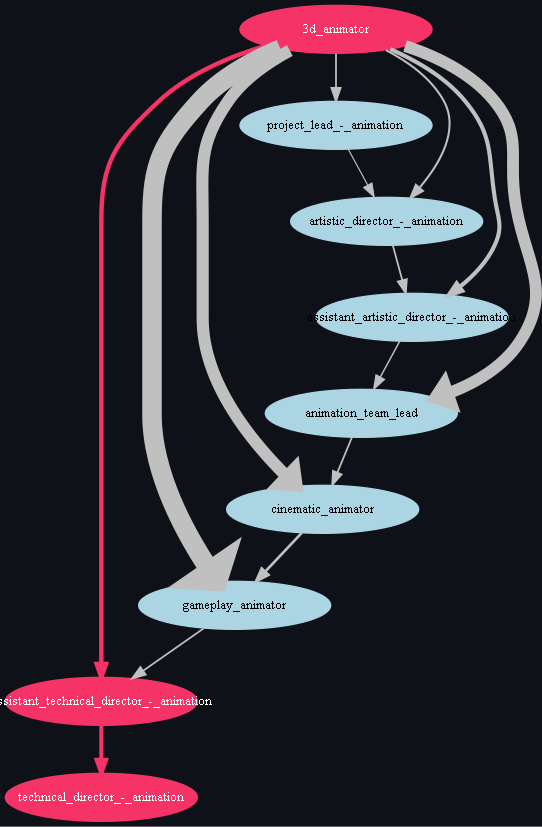

Optimal path ['3d_animator', 'assistant_technical_director_-_animation', 'technical_director_-_animation']


14

In [37]:
state_from = '3d_animator'
state_to = 'technical_director_-_animation'
viz_paths(G, state_from, state_to, '11')
edges_agg.loc[('3d_animator','assistant_technical_director_-_animation')]

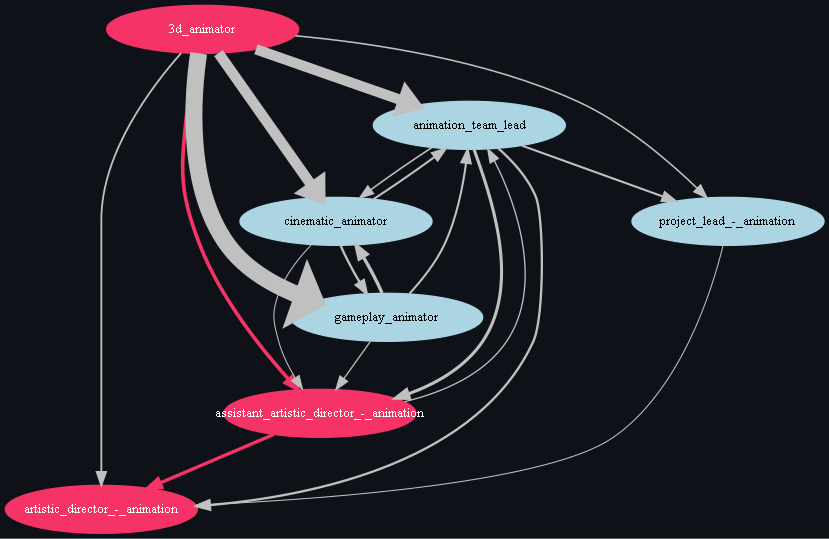

Optimal path ['3d_animator', 'assistant_artistic_director_-_animation', 'artistic_director_-_animation']


6

In [38]:
state_from = '3d_animator'
state_to = 'artistic_director_-_animation'
viz_paths(G, state_from, state_to, '22')
edges_agg.loc[(state_from, state_to)]

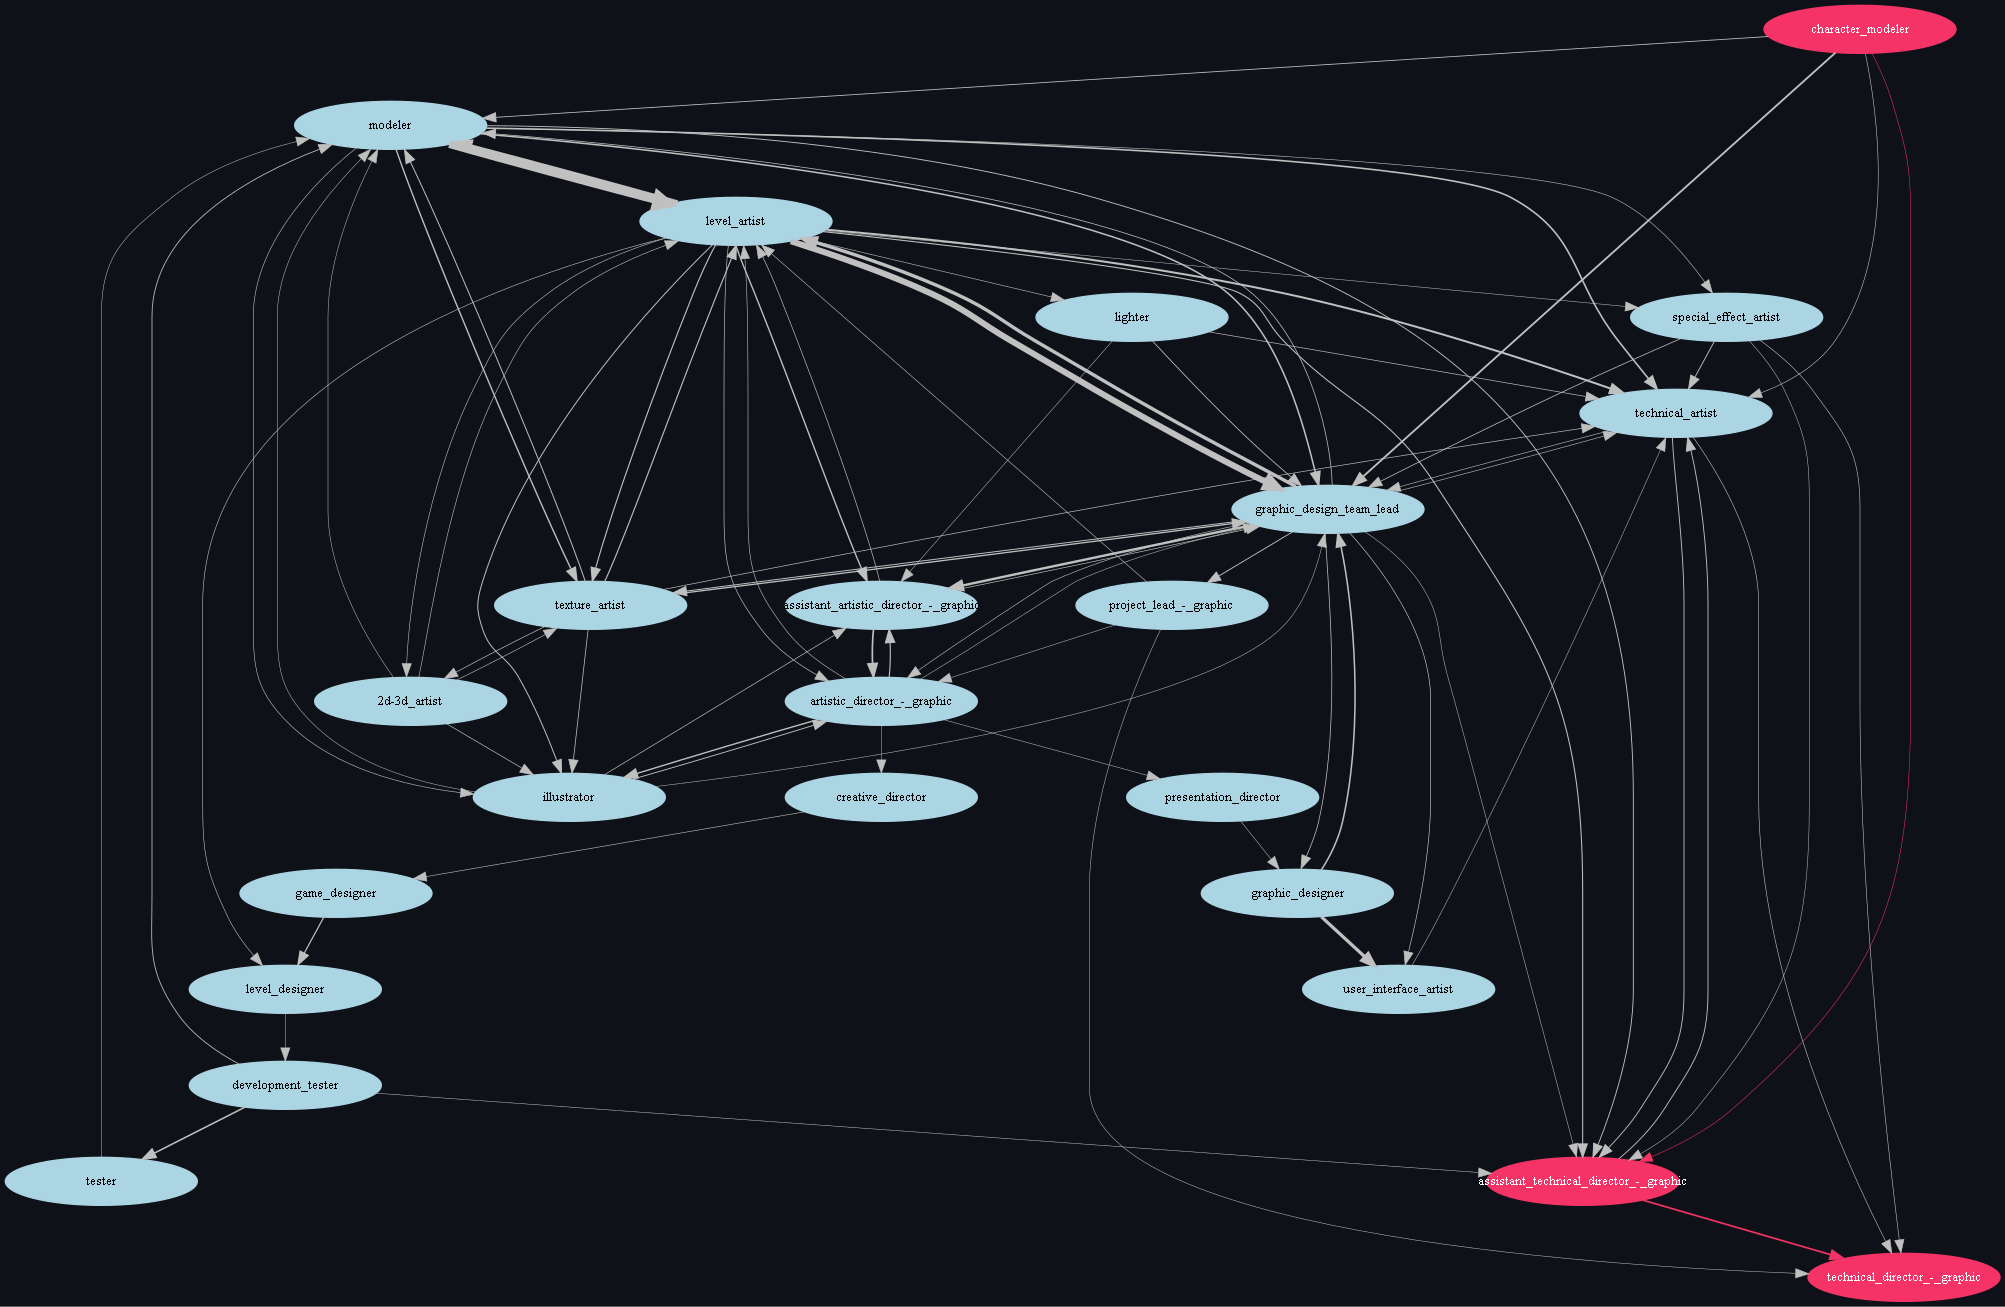

Optimal path ['character_modeler', 'assistant_technical_director_-_graphic', 'technical_director_-_graphic']


In [39]:
state_from = 'character_modeler'
state_to = 'technical_director_-_graphic'
viz_paths(G, state_from, state_to, '33')

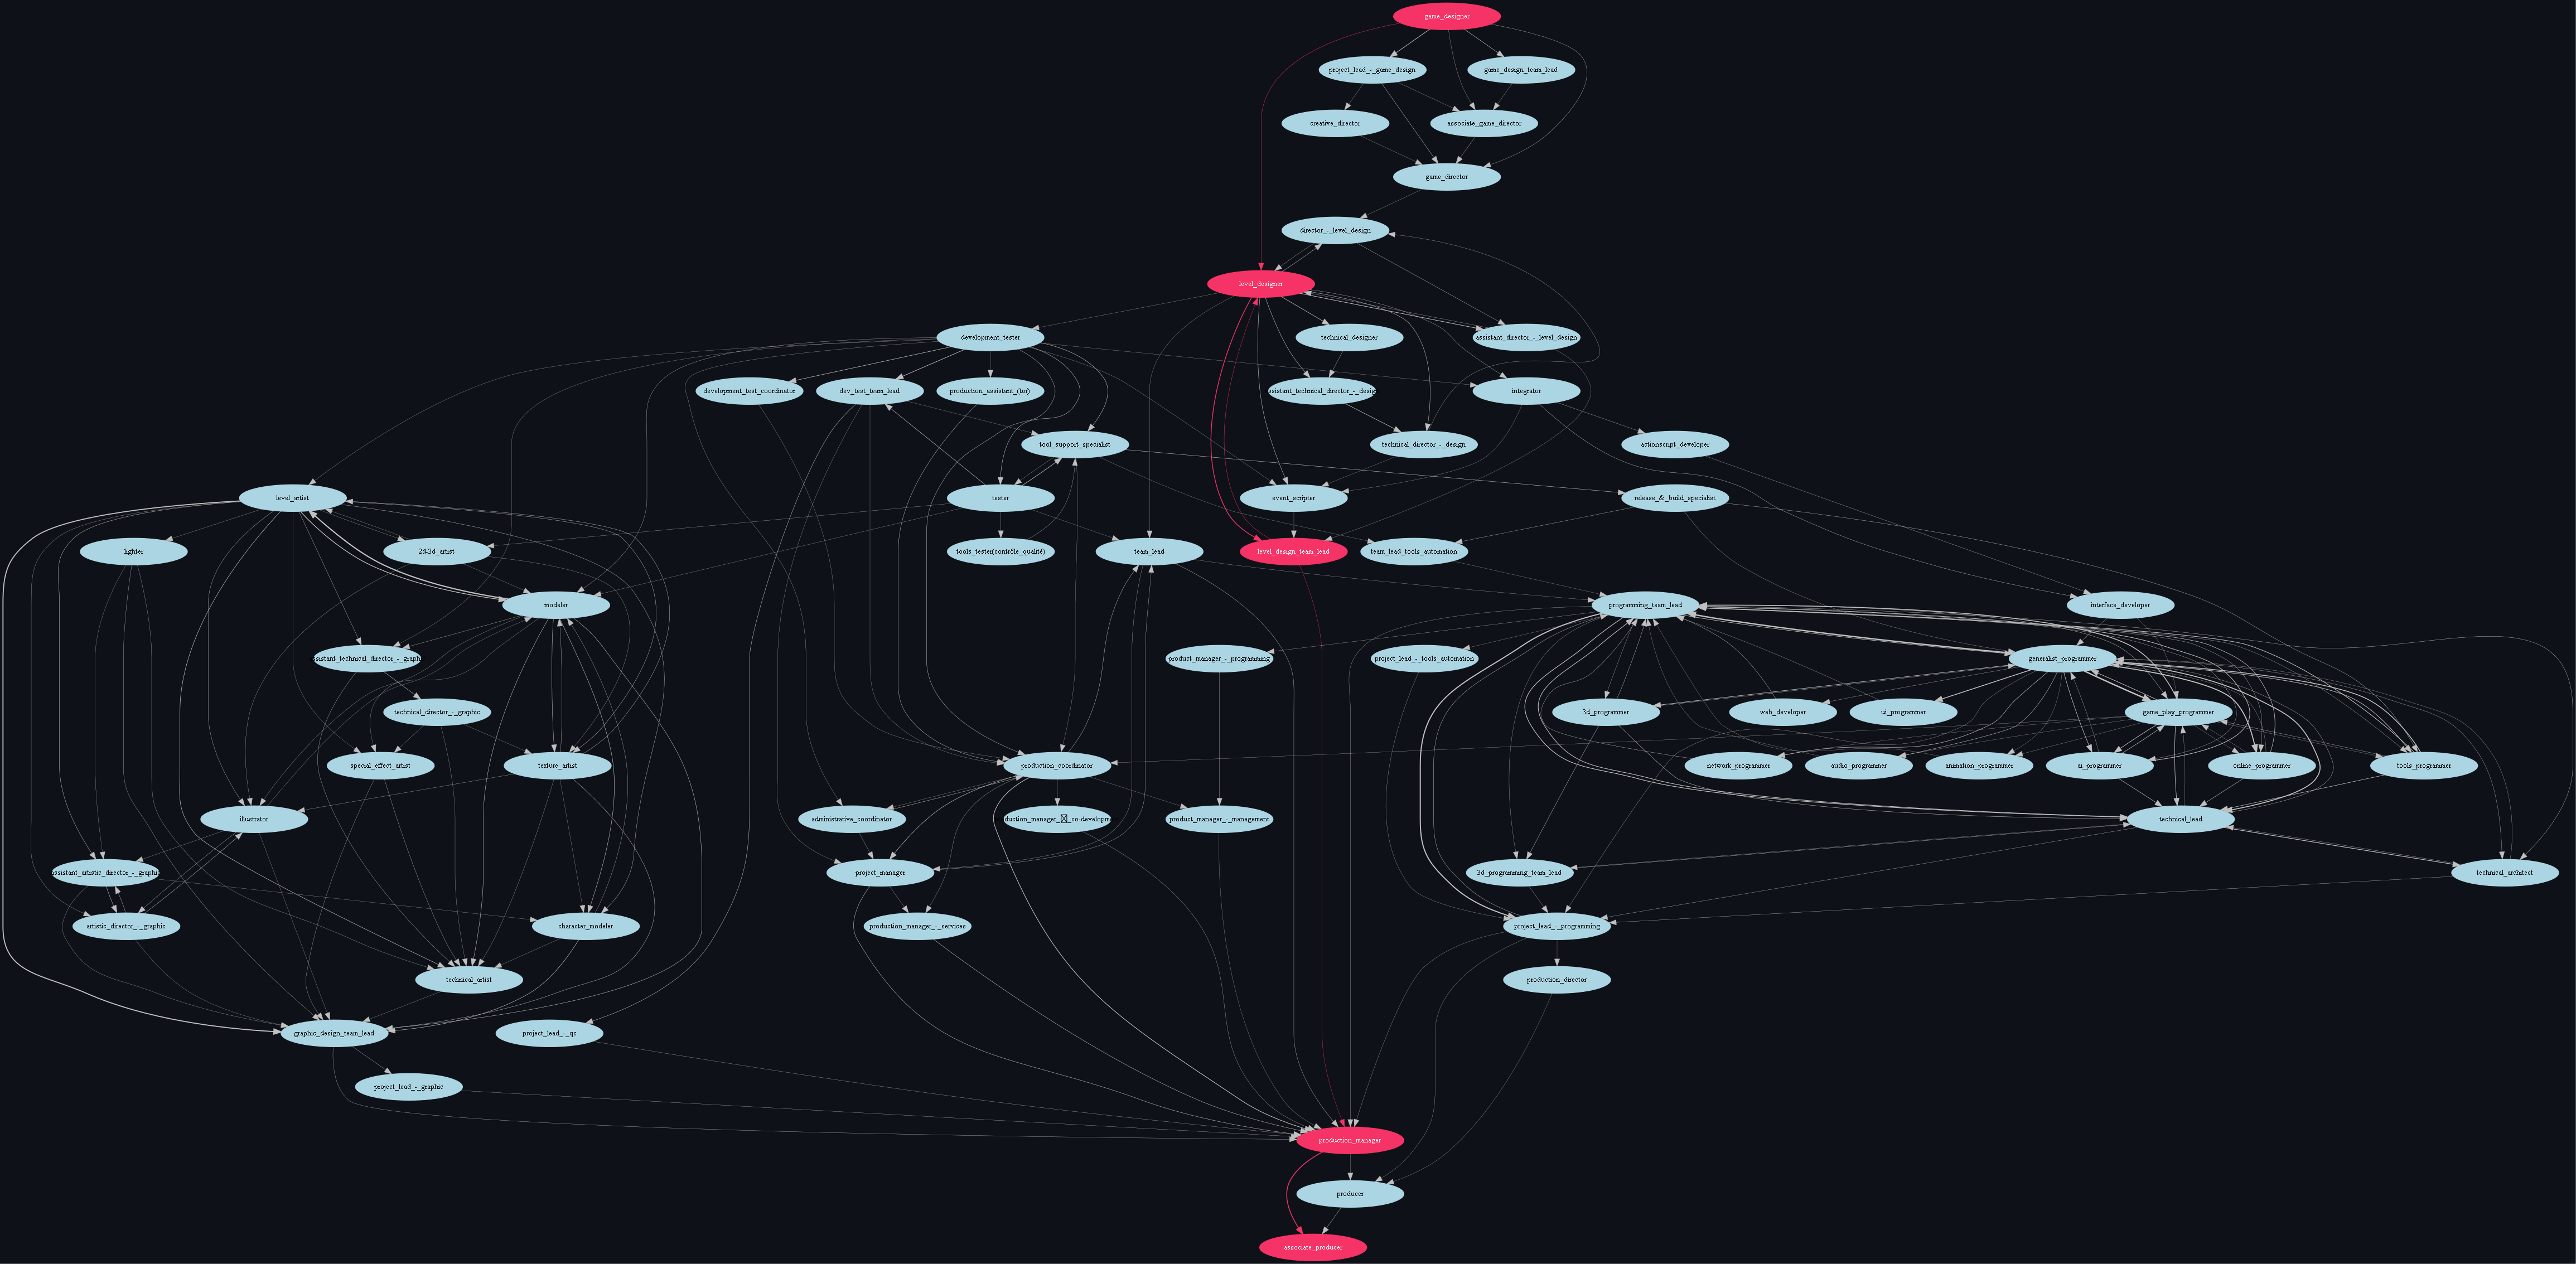

Optimal path ['game_designer', 'level_designer', 'level_design_team_lead', 'production_manager', 'associate_producer']


In [40]:
state_from = 'game_designer'
state_to = 'associate_producer'
viz_paths(G, state_from, state_to, '44')

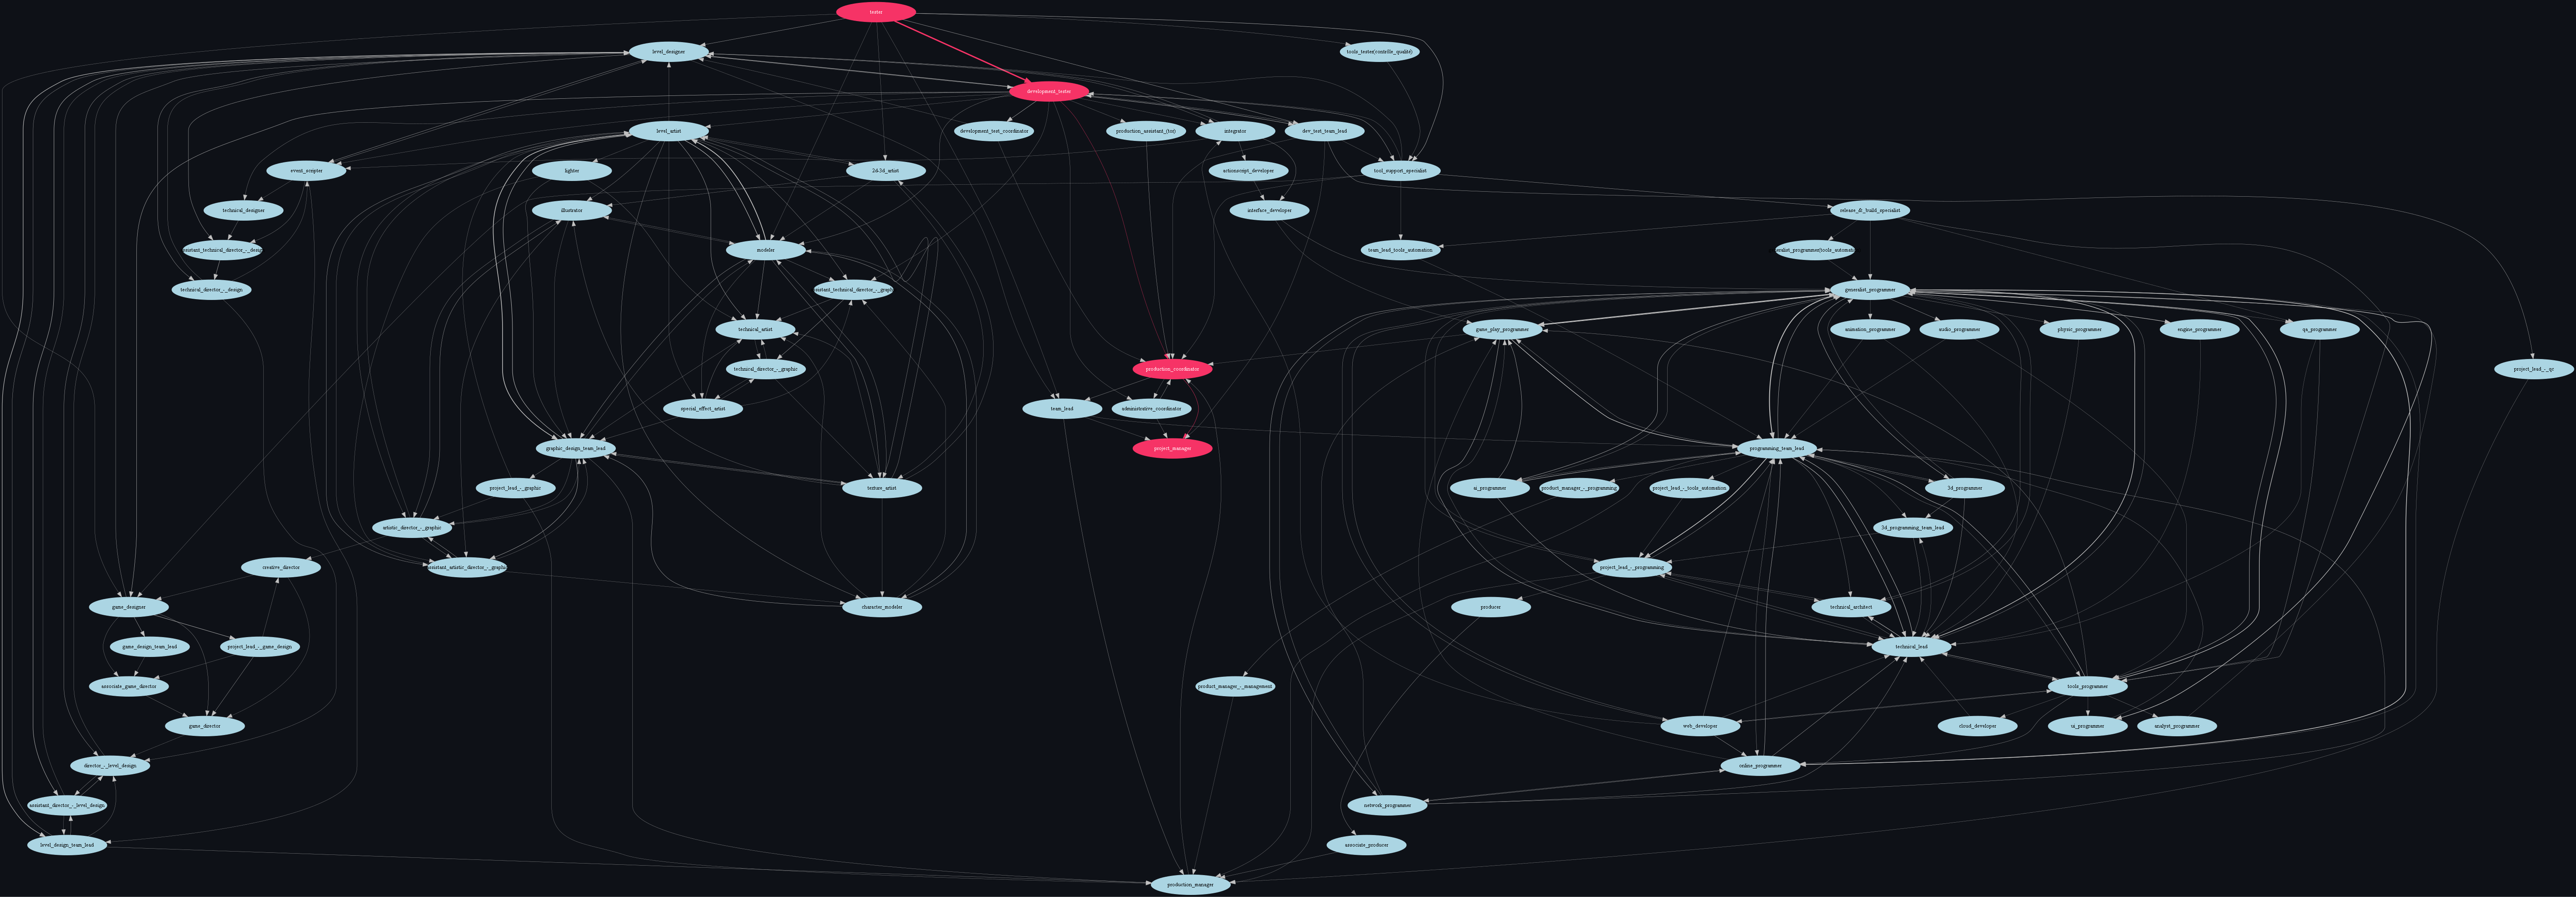

Optimal path ['tester', 'development_tester', 'production_coordinator', 'project_manager']


In [41]:
state_from = 'tester'
state_to = 'project_manager'
viz_paths(G, state_from, state_to, '55')

In [42]:
# plt.figure(figsize=(14,7))
# pos = nx.spring_layout(sg)
# nx.draw(sg, pos, with_labels=True, connectionstyle='arc3, rad = 0.1')
# edge_labels=dict([((u,v,),d['weight'])
#              for u,v,d in s.edges(data=True)])
# nx.draw_networkx_edge_labels(s, pos, edge_labels=edge_labels, label_pos=0.3, font_size=7)
# plt.show()